# 003. XGBoost 

## 1. Loading the dataset, setting up the trainere

In [1]:
# Libraries

In [2]:
import numpy as np
import random
SEED = 420 # Choose any integer
np.random.seed(SEED)
random.seed(SEED)

In [3]:
import os
import sys
import pandas as pd
import numpy as np

df = pd.read_csv(r'..\data\processed\scdb_final.csv')

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
# ---------------------------------------------

# Import .py xgboost trainer 
from src.train_model import XGBoostModelTrainer, load_model_for_xai

# Initialize trainer with CUDA support - later on will be reapplied
trainer = XGBoostModelTrainer(
    output_dir="../models",
    plot_dir="../plots", 
    enable_cuda=True,      # Automatically detects and uses GPU if available
    random_state=420,
    organize_by_model=True # Creates separate folders for each model
)

print(f"Trainer initialized. Using device: {trainer.device_info['device_name'].upper()}")

# Store all results for final comparison (THIS IS THE MISSING LINE)
all_results = {}

CUDA detected: 3 GPU(s) available
Trainer initialized. Using device: CUDA


## 2. Variable documentation

### Feature Documentation

#### Temporal Features

##### `month_of_argument`
Month (1-12) when oral arguments were held.
- Earlier months (Oct-Dec) = beginning of term
- Later months (Apr-Jun) = end of term rush
- May indicate workload patterns

##### `month_of_decision`
Month (1-12) when the decision was announced.
- June decisions often rushed (end of term)
- May affect deliberation quality/time

##### `year_of_decision`
Calendar year of the decision.
- Captures temporal trends in court efficiency
- May correlate with historical events/court composition

##### `days_term_start_to_argument`
Days from term start (Oct 1) to oral argument.
- Early term arguments may have more deliberation time
- Late term arguments face deadline pressure

##### `days_term_start_to_decision`
Days from term start (Oct 1) to decision.
- Measures when in the term cycle decision occurs
- Later decisions may be more complex/contentious

##### `is_argument_late_in_term`
Binary flag: 1 if argued in April or later.
- Late arguments have less time before term ends
- May indicate expedited or important cases

##### `is_decision_late_in_term`
Binary flag: 1 if decided in May or later.
- Captures "June rush" effect
- May indicate complex/divided cases

#### Court Structure Features

##### `chief_justice_code`
Numeric code identifying the Chief Justice.
- Different chiefs may have different management styles
- Affects court efficiency and deliberation pace

##### `natural_court_period`
Code for stable membership periods.
- New justices may slow deliberations
- Established courts may work more efficiently

##### `court_term_year`
Supreme Court term year (Oct-June).
- Historical context for the case
- Captures era-specific patterns

#### Case Origin and Source

##### `case_origin_type`
Simplified grouping of originating court:
- 'Federal': Federal district/circuit courts
- 'State': State courts
- 'Other': Territorial, unknown, special

##### `case_source_type`
Simplified grouping of court directly reviewed:
- 'Federal': Federal courts
- 'State': State courts  
- 'Other': Special jurisdictions

#### Case Type and Jurisdiction

##### `case_docket_type`
Type of Supreme Court docket:
- 'Merits/Other': Standard argued cases
- 'Special Jurisdiction': Original/Miscellaneous

##### `jurisdiction_type`
How case reached Supreme Court:
- 'Discretionary': Certiorari (court chooses)
- 'Mandatory': Appeal/Original (must hear)
- 'Other': Writs, procedural, unknown

##### `cert_reason_category`
Grouped reasons for granting certiorari:
- 'Substantive Reasons': Important Q, conflicts
- 'Procedural/Administrative': No reason, N/A
- 'Other': Unknown, other reasons

#### Legal Issues

##### `specific_legal_issue_code`
Detailed numeric code for the specific legal issue.
- High cardinality (many unique values)
- More granular than broad issue area

##### `broad_issue_area`
Major subject matter categories:
- 'Economic Activity': Business, commerce
- 'Criminal Procedure': Rights of accused
- 'Civil Rights': Discrimination, voting
- 'Judicial Power': Court jurisdiction
- 'First Amendment': Speech, religion
- 'Other Constitutional': Due process, federalism
- 'Other Non-Constitutional': Unions, tax, etc.

##### `law_type_category`
Type of law being interpreted:
- 'Constitutional': Constitution/Amendments
- 'Statutory': Federal statutes
- 'Other/Unknown': Rules, state law, unclear

##### `supplemental_law_code`
Detailed code for specific law/statute.
- Supplements law_type with specifics
- High cardinality categorical

#### Party Configuration

##### `petitioner_type`
Simplified petitioner (appellant) category:
- 'Government': US/State/Local govt & agencies
- 'Private Entities': Individuals, business
- 'Other/Unknown': Unclear or special parties

##### `respondent_type`
Simplified respondent (appellee) category:
- Same categories as petitioner_type
- Captures party dynamics

##### `is_govt_vs_business_case`
Binary: 1 if government entity vs business.
- May have different deliberation patterns
- Captures David vs Goliath dynamics

##### `is_individual_vs_govt_case`
Binary: 1 if individual vs government.
- Often civil rights/liberties cases
- May require careful deliberation

##### `is_state_vs_state_case`
Binary: 1 if state government vs state government.
- Original jurisdiction cases
- Often boundary/water rights disputes

#### Lower Court Information

##### `lower_court_disagreement`
Binary: 1 if explicit lower court conflict.
- Major reason for Supreme Court review
- May require more deliberation to resolve

##### `lower_court_ideological_direction`
Lower court decision ideology:
- 1: Conservative
- 2: Liberal  
- 3: Unspecifiable/Missing

##### `lower_court_disposition_type`
How lower court decided:
- 'Affirmed': Upheld lower ruling
- 'Reversed/Modified': Changed ruling
- 'Other/Unknown': Procedural, unclear

##### `lower_court_disagree_ideology`
Interaction of disagreement and ideology:
- 'LC_Agree_Conservative': No conflict, conservative
- 'LC_Agree_Liberal': No conflict, liberal
- 'LC_Disagree_Conservative': Conflict, conservative
- 'LC_Disagree_Liberal': Conflict, liberal
- 'LC_Unspec/Other': Unclear

#### Case Complexity Indicators

##### `consolidated_dockets_count`
Number of dockets consolidated in this case.
- Higher = more complex (multiple related cases)
- May require longer deliberation

##### `case_had_reargument`
Binary: 1 if case was reargued.
- Indicates initial arguments insufficient
- Strong complexity/difficulty signal

##### `complexity_score_consolidated_disagree`
Interaction: dockets_count × lower_court_disagreement.
- Captures compounded complexity
- High values = consolidated cases with conflicts

##### `three_judge_district_court`
Binary: 1 if from 3-judge district court.
- Special federal court panels
- Often important constitutional cases

#### Specialized Features

##### `is_admin_economic_case`
Binary: 1 if administrative agency + economic issue.
- Regulatory/business intersection
- May have specialized complexity

##### `is_federal_circuit_conflict`
Binary: 1 if federal circuit court with conflict.
- Circuit splits are key cert reason
- Requires harmonizing precedents

#### Interaction Features

##### `issue_jurisdiction_interaction`
Concatenated issue area + jurisdiction path.
- Captures if certain issues via certain paths
  have distinct duration patterns

##### `three_judge_issue_interaction`
Concatenated issue area + three-judge flag.
- Tests if 3-judge court effect varies by issue

#### Target Variable

##### `case_duration_days`
TARGET VARIABLE: Days from argument to decision.
- What we're predicting
- Measures deliberation time

#### Missing Value Indicators

##### `lower_court_disagree_was_missing`
Binary: 1 if lcDisagreement was originally missing.
- Allows model to learn from missingness pattern
- Missing may indicate certain case types

##### `three_judge_info_was_missing`
Binary: 1 if threeJudgeFdc was originally missing.
- Captures data quality/availability patterns

#### Derived Features

##### `decision_timing_category`
Binned version of duration_days.
- Could be used for classification instead of regression
- Categories like 'Quick', 'Normal', 'Slow'

## 2. Mapping names of the model and grouping features

In [41]:
# Create a mapping dictionary for cleaner column names
feature_name_mapping = {
    # Temporal Features
    'argument_month': 'month_of_argument',
    'decision_month': 'month_of_decision', 
    'decision_year': 'year_of_decision',
    'days_from_term_start_to_argument': 'days_term_start_to_argument',
    'days_from_term_start_to_decision': 'days_term_start_to_decision',
    'is_late_term_argument': 'is_argument_late_in_term',
    'is_late_term_decision': 'is_decision_late_in_term',
    
    # Court Structure Features
    'chief': 'chief_justice_sname',
    'naturalCourt': 'natural_court_period',
    'term': 'court_term_year',
    
    # Case Origin and Source
    'caseOrigin_group': 'case_origin_type',
    'caseSource_group': 'case_source_type',
    
    # Case Type and Jurisdiction
    'docket_category': 'case_docket_type',
    'jurisdiction_group': 'jurisdiction_type',
    'certReason_group': 'cert_reason_category',
    
    # Legal Issues
    'issue': 'specific_legal_issue_code',
    'issueArea_name': 'broad_issue_area',
    'lawType_group': 'law_type_category',
    'lawSupp': 'supplemental_law_code',
    
    # Party Configuration
    'petitioner_group': 'petitioner_type',
    'respondent_group': 'respondent_type',
    'is_Govt_vs_Business': 'is_govt_vs_business_case',
    'is_Individual_vs_Govt': 'is_individual_vs_govt_case',
    'is_State_vs_State': 'is_state_vs_state_case',
    
    # Lower Court Information
    'lcDisagreement': 'lower_court_disagreement',
    'lcDispositionDirection': 'lower_court_ideological_direction',
    'lcDisposition_group': 'lower_court_disposition_type',
    'lc_disagree_direction': 'lower_court_disagree_ideology',
    
    # Case Complexity Indicators
    'num_dockets_in_case': 'consolidated_dockets_count',
    'had_reargument': 'case_had_reargument',
    'complex_consolidated_disagreement': 'complexity_score_consolidated_disagree',
    'threeJudgeFdc': 'three_judge_district_court',
    
    # Specialized Features
    'is_AdminAction_x_Economic': 'is_admin_economic_case',
    'is_FedCirc_Conflict': 'is_federal_circuit_conflict',
    
    # Interaction Features
    'issue_x_jurisdiction': 'issue_jurisdiction_interaction',
    'threeJudge_x_issue': 'three_judge_issue_interaction',
    
    # Target Variable
    'duration_days': 'case_duration_days',
    
    # Missing Value Indicators
    'lcDisagreement_is_missing': 'lower_court_disagree_was_missing',
    'threeJudgeFdc_is_missing': 'three_judge_info_was_missing',
    
    # Derived Features
    'decision_timing_bin': 'decision_timing_category'
}

# Apply the mapping to rename columns
df = df.rename(columns=feature_name_mapping)
print(df.columns.tolist())


# Print summary of features by category
print("=== FEATURE CATEGORIES AND COUNTS ===\n")

feature_categories = {
    'Temporal Features': ['month_of_argument', 'month_of_decision', 'year_of_decision', 
                         'days_term_start_to_argument', 'days_term_start_to_decision',
                         'is_argument_late_in_term', 'is_decision_late_in_term'],
    'Court Structure': ['chief_justice_code', 'natural_court_period', 'court_term_year'],
    'Case Origin/Source': ['case_origin_type', 'case_source_type'],
    'Case Type/Jurisdiction': ['case_docket_type', 'jurisdiction_type', 'cert_reason_category'],
    'Legal Issues': ['specific_legal_issue_code', 'broad_issue_area', 'law_type_category', 'supplemental_law_code'],
    'Party Configuration': ['petitioner_type', 'respondent_type', 'is_govt_vs_business_case',
                           'is_individual_vs_govt_case', 'is_state_vs_state_case'],
    'Lower Court Info': ['lower_court_disagreement', 'lower_court_ideological_direction',
                        'lower_court_disposition_type', 'lower_court_disagree_ideology'],
    'Complexity Indicators': ['consolidated_dockets_count', 'case_had_reargument',
                             'complexity_score_consolidated_disagree', 'three_judge_district_court'],
    'Specialized Features': ['is_admin_economic_case', 'is_federal_circuit_conflict'],
    'Interaction Features': ['issue_jurisdiction_interaction', 'three_judge_issue_interaction'],
    'Missing Indicators': ['lower_court_disagree_was_missing', 'three_judge_info_was_missing'],
    'Target/Derived': ['case_duration_days', 'decision_timing_category']
}

for category, features in feature_categories.items():
    print(f"{category}: {len(features)} features")
    
print(f"\nTotal features: {sum(len(f) for f in feature_categories.values())}")

['month_of_argument', 'case_origin_type', 'case_source_type', 'cert_reason_category', 'chief_justice_sname', 'complexity_score_consolidated_disagree', 'days_term_start_to_argument', 'days_term_start_to_decision', 'month_of_decision', 'year_of_decision', 'case_docket_type', 'case_had_reargument', 'is_admin_economic_case', 'is_federal_circuit_conflict', 'is_govt_vs_business_case', 'is_individual_vs_govt_case', 'is_state_vs_state_case', 'is_argument_late_in_term', 'is_decision_late_in_term', 'specific_legal_issue_code', 'broad_issue_area', 'issue_jurisdiction_interaction', 'jurisdiction_type', 'supplemental_law_code', 'law_type_category', 'lower_court_disagreement', 'lower_court_ideological_direction', 'lower_court_disposition_type', 'lower_court_disagree_ideology', 'natural_court_period', 'consolidated_dockets_count', 'petitioner_type', 'respondent_type', 'court_term_year', 'three_judge_district_court', 'three_judge_issue_interaction', 'case_duration_days', 'lower_court_disagree_was_miss

In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# ========================================
# STEP 1: Apply Feature Renaming
# ========================================
print("=== STEP 1: Renaming Features ===")
df_renamed = df.rename(columns=feature_name_mapping)
print(f"Features renamed. New shape: {df_renamed.shape}")


# ========================================
# STEP 2: Handle Problematic Features
# ========================================
print("\n=== STEP 2: Handling Problematic Features ===")

# 2.1: Drop high-cardinality interaction features that may cause overfitting
features_to_drop = [
    'issue_jurisdiction_interaction',  # Too many unique combinations
    'three_judge_issue_interaction',   # Too many unique combinations
    'supplemental_law_code',           # Very high cardinality, limited interpretability
    'case_had_reargument'              # is only known AFTER the initial oral arguments, potentially leaks future information
]

print(f"Dropping {len(features_to_drop)} high-cardinality features...")
df_cleaned = df_renamed.drop(columns=[f for f in features_to_drop if f in df_renamed.columns])
print(f"New shape after dropping: {df_cleaned.shape}")

# 2.2: Handle 'specific_legal_issue_code' - create frequency-based groups
print("\nGrouping rare legal issues...")
issue_counts = df_cleaned['specific_legal_issue_code'].value_counts()
rare_issues = issue_counts[issue_counts < 30].index  # Issues with less than 30 cases
df_cleaned['specific_legal_issue_grouped'] = df_cleaned['specific_legal_issue_code'].apply(
    lambda x: 'rare_issue' if x in rare_issues else str(x)
)
# Drop the original high-cardinality column
df_cleaned = df_cleaned.drop('specific_legal_issue_code', axis=1)


# ========================================
# STEP 3: Separate Features by Type
# ========================================
print("\n=== STEP 3: Identifying Feature Types ===")

# Define numerical features (continuous values)
numerical_features = [
    'month_of_argument',
    'month_of_decision', 
    'year_of_decision',
    'days_term_start_to_argument',
    'days_term_start_to_decision',
    #'chief_justice_code',
    'natural_court_period',
    'court_term_year',
    'lower_court_disagreement',
    'lower_court_ideological_direction',
    'consolidated_dockets_count',
    'complexity_score_consolidated_disagree',
    'three_judge_district_court'
]

# Define binary features (0/1 flags)
binary_features = [
    'is_argument_late_in_term',
    'is_decision_late_in_term',
    'case_had_reargument',
    'is_govt_vs_business_case',
    'is_individual_vs_govt_case',
    'is_state_vs_state_case',
    'is_admin_economic_case',
    'is_federal_circuit_conflict',
    'lower_court_disagree_was_missing',
    'three_judge_info_was_missing'
]

# Define categorical features (need encoding)
categorical_features = [
    'case_origin_type',
    'case_source_type',
    'case_docket_type',
    'jurisdiction_type',
    'cert_reason_category',
    'broad_issue_area',
    'law_type_category',
    'petitioner_type',
    'respondent_type',
    'lower_court_disposition_type',
    'lower_court_disagree_ideology',
    'specific_legal_issue_grouped',  # Our new grouped feature
    'decision_timing_category',
    'chief_justice_sname'  
]

# Remove any features that don't exist in the dataframe
numerical_features = [f for f in numerical_features if f in df_cleaned.columns]
binary_features = [f for f in binary_features if f in df_cleaned.columns]
categorical_features = [f for f in categorical_features if f in df_cleaned.columns]

print(f"Numerical features: {len(numerical_features)}")
print(f"Binary features: {len(binary_features)}")
print(f"Categorical features: {len(categorical_features)}")


# ========================================
# STEP 4: Create Feature Sets for Modeling
# ========================================
print("\n=== STEP 4: Creating Feature Sets ===")

# 4.1: Basic feature set (most reliable features)
basic_features = [
    # Temporal
    'month_of_argument', 'month_of_decision', 'year_of_decision',
    'is_argument_late_in_term', 'is_decision_late_in_term',
    # Court
    'court_term_year', 'natural_court_period',
    # Case type
    'case_docket_type', 'jurisdiction_type', 'broad_issue_area',
    # Parties
    'petitioner_type', 'respondent_type',
    # Complexity
    'consolidated_dockets_count', 'case_had_reargument',
    # Lower court
    'lower_court_disagreement', 'lower_court_disposition_type'
]

# 4.2: Extended feature set (includes more features)
extended_features = basic_features + [
    'days_term_start_to_argument', 'days_term_start_to_decision',
    'cert_reason_category', 'law_type_category',
    'is_govt_vs_business_case', 'is_individual_vs_govt_case',
    'complexity_score_consolidated_disagree',
    'lower_court_ideological_direction', 'lower_court_disagree_ideology'
]

# 4.3: Full feature set (everything except dropped)
# Ensure they only contain features present in df_cleaned
basic_features_final = [f for f in basic_features if f in df_cleaned.columns]
extended_features_final = [f for f in extended_features if f in df_cleaned.columns]
full_features_final = [col for col in df_cleaned.columns if col not in ['case_duration_days', 'decision_timing_category']] # Assuming this is how you defined it

print(f"Basic feature set: {len(basic_features_final)} features")
print(f"Extended feature set: {len(extended_features_final)} features")
print(f"Full feature set: {len(full_features_final)} features")


# ========================================
# STEP 5 & 6 COMBINED: Prepare Data and Configurations for Each Feature Set
# ========================================
print("\n=== STEP 5 & 6: Preparing Data and Configurations for Each Feature Set ===")

all_model_inputs = {}
y = df_cleaned['case_duration_days'] # Target is the same for all

feature_sets_to_prepare = {
    "basic": basic_features_final,
    "extended": extended_features_final,
    "full": full_features_final
}

for set_name, selected_features_list in feature_sets_to_prepare.items():
    print(f"\n--- Preparing for feature set: {set_name.upper()} ---")

    # Create X for the current feature set
    X_current = df_cleaned[selected_features_list]
    print(f"X_{set_name} shape: {X_current.shape}")

    # Identify numerical vs categorical for the trainer for this specific X_current
    current_numerical = [f for f in numerical_features if f in X_current.columns]
    current_binary = [f for f in binary_features if f in X_current.columns] # Global binary list filtered by X_current
    current_categorical = [f for f in categorical_features if f in X_current.columns] # Global categorical list filtered by X_current

    # For XGBoostModelTrainer, combine numerical and binary
    current_numerical_for_trainer = current_numerical + current_binary
    current_categorical_for_trainer = current_categorical

    print(f"For XGBoostModelTrainer ({set_name} set):")
    print(f"  Numerical features: {len(current_numerical_for_trainer)}")
    print(f"  Categorical features: {len(current_categorical_for_trainer)}")

    # Store the prepared inputs
    all_model_inputs[set_name] = {
        'X': X_current,
        'y': y, # y is the same
        'numerical_for_trainer': current_numerical_for_trainer,
        'categorical_for_trainer': current_categorical_for_trainer,
        'feature_list': selected_features_list # Optional: store the list of features used
    }

# At this point, all_model_inputs dictionary contains everything needed for each feature set.
# Example: all_model_inputs['extended']['X'] will give you the X for the extended feature set.

print(f"\nTarget statistics (applies to all sets):")
print(f"  Mean duration: {y.mean():.1f} days")
print(f"  Median duration: {y.median():.1f} days")
print(f"  Std deviation: {y.std():.1f} days")

# ========================================
# STEP 7: Feature Importance Analysis Setup (Adjust as needed)
# ========================================
# Your feature_groups might need to be defined per selected_features set if you run analysis
# specifically tied to a model trained on that set. Or, define it based on the 'full_features_final'
# set if you want a comprehensive grouping for general analytical purposes.
# For now, this will be based on the last 'selected_features_list' in the loop,
# or you can define it based on a specific set like extended_features_final.
# Let's base it on extended_features_final for this example:

print("\n=== STEP 7: Feature Analysis Preparation (Example for Extended Set) ===")
selected_features_for_groups = extended_features_final # Or choose another default

feature_groups = {
    'Temporal': [f for f in ['month_of_argument', 'month_of_decision', 'year_of_decision',
                             'days_term_start_to_argument', 'days_term_start_to_decision',
                             'is_argument_late_in_term', 'is_decision_late_in_term']
                 if f in selected_features_for_groups],
    'Court Structure': [f for f in ['chief_justice_code', 'natural_court_period', 'court_term_year']
                        if f in selected_features_for_groups],
    'Case Type': [f for f in ['case_docket_type', 'jurisdiction_type', 'cert_reason_category']
                  if f in selected_features_for_groups],
    'Legal Issues': [f for f in ['broad_issue_area', 'law_type_category', 'specific_legal_issue_grouped']
                     if f in selected_features_for_groups],
    'Parties': [f for f in ['petitioner_type', 'respondent_type', 'is_govt_vs_business_case',
                           'is_individual_vs_govt_case', 'is_state_vs_state_case']
                if f in selected_features_for_groups],
    'Lower Court': [f for f in ['lower_court_disagreement', 'lower_court_disposition_type',
                               'lower_court_ideological_direction', 'lower_court_disagree_ideology']
                    if f in selected_features_for_groups],
    'Complexity': [f for f in ['consolidated_dockets_count', 'case_had_reargument',
                               'complexity_score_consolidated_disagree']
                   if f in selected_features_for_groups]
}

print("\nFeature groups for importance analysis (based on extended set):")
for group, features in feature_groups.items():
    print(f"  {group}: {len(features)} features")


print("\n=== PREPROCESSING COMPLETE FOR MULTIPLE FEATURE SETS ===")
print("Ready for model training with XGBoostModelTrainer using inputs from 'all_model_inputs' dictionary!")
print("\nNext steps:")
print("1. In your scenario script, loop through all_model_inputs or pick specific sets:")
print("   for set_name, inputs in all_model_inputs.items():")
print("       results = trainer.train_model(X=inputs['X'], y=inputs['y'], ...)")
print("2. Analyze feature importance results for each model.")
print("3. Compare performance across models trained on different feature sets.")

=== STEP 1: Renaming Features ===
Features renamed. New shape: (9534, 40)

=== STEP 2: Handling Problematic Features ===
Dropping 4 high-cardinality features...
New shape after dropping: (9534, 36)

Grouping rare legal issues...

=== STEP 3: Identifying Feature Types ===
Numerical features: 12
Binary features: 9
Categorical features: 14

=== STEP 4: Creating Feature Sets ===
Basic feature set: 15 features
Extended feature set: 24 features
Full feature set: 34 features

=== STEP 5 & 6: Preparing Data and Configurations for Each Feature Set ===

--- Preparing for feature set: BASIC ---
X_basic shape: (9534, 15)
For XGBoostModelTrainer (basic set):
  Numerical features: 9
  Categorical features: 6

--- Preparing for feature set: EXTENDED ---
X_extended shape: (9534, 24)
For XGBoostModelTrainer (extended set):
  Numerical features: 15
  Categorical features: 9

--- Preparing for feature set: FULL ---
X_full shape: (9534, 34)
For XGBoostModelTrainer (full set):
  Numerical features: 21
  Ca

In [98]:
# def get_variable_type(variable):
#     if hasattr(variable, 'dtype'):
#         if pd.api.types.is_numeric_dtype(variable):
#             if pd.api.types.is_bool_dtype(variable):
#                 return "boolean (numerical by dtype, often categorical)"
#             return "numerical"
#         elif pd.api.types.is_categorical_dtype(variable):
#             return "categorical (explicit)"
#         elif pd.api.types.is_object_dtype(variable) or \
#              pd.api.types.is_string_dtype(variable):
#             return "categorical (object/string)"
#         elif pd.api.types.is_datetime64_any_dtype(variable) or \
#              pd.api.types.is_timedelta64_dtype(variable):
#             return "datetime/timedelta"
#         else:
#             return f"other pandas dtype ({variable.dtype})"
#     else:
#         if isinstance(variable, (int, float, complex)):
#             return "numerical (basic type)"
#         elif isinstance(variable, str):
#             return "categorical (string basic type)"
#         elif isinstance(variable, bool):
#             return "boolean (basic type)"
#         else:
#             return "other basic type"
# # --- End of assumed pre-defined items ---


# # Get automated types for all columns in df_cleaned
# automated_column_types = {}
# for col_name in df_cleaned.columns:
#     automated_column_types[col_name] = get_variable_type(df_cleaned[col_name])

# # --- Identify Discrepancies ---
# discrepancy_list = {} # Using a dict to store more info: {col_name: reason}
# all_manually_listed_features = set(numerical_features + binary_features + categorical_features)

# # Check numerical features
# for col_name in numerical_features:
#     if col_name in df_cleaned.columns:
#         auto_type = automated_column_types[col_name]
#         # A feature listed as numerical should ideally be 'numerical' or 'boolean (numerical by dtype, often categorical)'
#         if not (auto_type == "numerical" or auto_type == "boolean (numerical by dtype, often categorical)"):
#             discrepancy_list[col_name] = (f"Manually 'numerical', "
#                                           f"Auto '{auto_type}' (Dtype: {df_cleaned[col_name].dtype})")
#     else:
#         discrepancy_list[col_name] = "Manually 'numerical', but Column NOT FOUND in DataFrame"

# # Check binary features
# for col_name in binary_features:
#     if col_name in df_cleaned.columns:
#         auto_type = automated_column_types[col_name]
#         # Binary features are typically numeric (int/float for 0/1) or boolean
#         if not (auto_type == "numerical" or auto_type == "boolean (numerical by dtype, often categorical)"):
#             discrepancy_list[col_name] = (f"Manually 'binary', "
#                                           f"Auto '{auto_type}' (Dtype: {df_cleaned[col_name].dtype})")
#     else:
#         discrepancy_list[col_name] = "Manually 'binary', but Column NOT FOUND in DataFrame"

# # Check categorical features
# for col_name in categorical_features:
#     if col_name in df_cleaned.columns:
#         auto_type = automated_column_types[col_name]
#         # Categorical can be explicit, object/string, or even boolean
#         if not (auto_type == "categorical (explicit)" or \
#                 auto_type == "categorical (object/string)" or \
#                 auto_type == "boolean (numerical by dtype, often categorical)"):
#             discrepancy_list[col_name] = (f"Manually 'categorical', "
#                                           f"Auto '{auto_type}' (Dtype: {df_cleaned[col_name].dtype})")
#     else:
#         discrepancy_list[col_name] = "Manually 'categorical', but Column NOT FOUND in DataFrame"

# # Check for columns in DataFrame but not in any manual list (unclassified)
# for col_name in df_cleaned.columns:
#     if col_name not in all_manually_listed_features:
#         auto_type = automated_column_types[col_name]
#         discrepancy_list[col_name] = (f"Unclassified (not in manual lists), "
#                                       f"Auto '{auto_type}' (Dtype: {df_cleaned[col_name].dtype})")


# # --- Display Value Counts for Discrepant/Unclassified Columns ---
# print("\n--- Columns Requiring Manual Review (Discrepancies or Unclassified) ---")
# if not discrepancy_list:
#     print("No discrepancies found and all columns are classified!")
# else:
#     for col_name, reason in discrepancy_list.items():
#         print(f"\nColumn: '{col_name}'")
#         print(f"Reason for review: {reason}")
#         if col_name in df_cleaned.columns:
#             print(f"Actual Dtype in DataFrame: {df_cleaned[col_name].dtype}")
#             print("Value Counts (dropna=False to include NaNs):")
#             # Show more values if unique count is low, otherwise top N
#             if df_cleaned[col_name].nunique(dropna=False) <= 20:
#                  print(df_cleaned[col_name].value_counts(dropna=False))
#             else:
#                 print(df_cleaned[col_name].value_counts(dropna=False).head(10))
#                 if df_cleaned[col_name].nunique(dropna=False) > 10:
#                     print(f"... and {df_cleaned[col_name].nunique(dropna=False) - 10} more unique values.")
#             print("-" * 40)
#         else:
#             print("This column was not found in the DataFrame, so no value counts can be shown.")
#             print("-" * 40)

## 3. Modelling 

In [99]:
X_current

month_of_argument case_origin_type case_source_type  \
0                     1          Federal          Federal   
1                    10          Federal          Federal   
2                    10          Federal          Federal   
3                    10          Federal          Federal   
4                    10          Federal          Federal   
...                 ...              ...              ...   
9529                  4          Federal          Federal   
9530                  4          Federal          Federal   
9531                  4          Federal          Federal   
9532                  2          Federal          Federal   
9533                  2          Federal          Federal   

           cert_reason_category chief_justice_sname  \
0           Substantive Reasons              Vinson   
1           Substantive Reasons              Vinson   
2           Substantive Reasons              Vinson   
3           Substantive Reasons              Vinson   
4           Substantive Reasons              Vinson   
...                         ...                 ...   
9529  Procedural/Administrative             Roberts   
9530  Procedural/Administrative             Roberts   
9531        Substantive Reasons             Roberts   
9532        Substantive Reasons             Roberts   
9533        Substantive Reasons             Roberts   

      complexity_score_consolidated_disagree  days_term_start_to_argument  \
0                                        0.0                            0   
1                                        0.0                            0   
2                                        0.0                            0   
3                                        0.0                            0   
4                                        0.0                            0   
...                                      ...                          ...   
9529                                     0.0                          206   
9530                                     0.0                          206   
9531                                     0.0                          207   
9532                                     0.0                          148   
9533                                     2.0                          148   

      days_term_start_to_decision  month_of_decision  year_of_decision  ...  \
0                              48                 11              1946  ...   
1                              48                 11              1946  ...   
2                              48                 11              1946  ...   
3                              48                 11              1946  ...   
4                              48                 11              1946  ...   
...                           ...                ...               ...  ...   
9529                          270                  6              2024  ...   
9530                          270                  6              2024  ...   
9531                          274                  7              2024  ...   
9532                          274                  7              2024  ...   
9533                          274                  7              2024  ...   

     lower_court_disagree_ideology  natural_court_period  \
0            LC_Agree_Conservative                  1301   
1            LC_Agree_Conservative                  1301   
2            LC_Agree_Conservative                  1301   
3            LC_Agree_Conservative                  1301   
4            LC_Agree_Conservative                  1301   
...                            ...                   ...   
9529              LC_Agree_Liberal                  1710   
9530              LC_Agree_Liberal                  1710   
9531         LC_Agree_Conservative                  1710   
9532              LC_Agree_Liberal                  1710   
9533      LC_Disagree_Conservative                  1710   

      consolidate

In [44]:
# =============================================================================
# SCDB CASE DURATION MODEL TRAINING SCENARIOS
# (Revised to loop through defined feature sets for Scenarios 1-3,
#  and includes Autogluon as Scenario 6)
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import os # For creating directories
import re # For parsing strings in sorting
from autogluon.tabular import TabularPredictor # Import Autogluon
from sklearn.model_selection import train_test_split # For Autogluon data split

# --- ASSUMPTIONS ---
# 1. Your 'trainer' (XGBoostModelTrainer instance) is already instantiated.
# 2. Your preprocessing script (Steps 1-4) has been run, defining:
#    - df_cleaned: The main cleaned DataFrame.
#    - y: The target variable (e.g., df_cleaned['case_duration_days']).
#    - Global feature type lists: numerical_features, binary_features, categorical_features (all from df_cleaned).
#    - Feature set lists: basic_features_final, extended_features_final, full_features_final.
#    These should be actual lists of column names present in df_cleaned.
#
# Example (ensure these are defined from your preprocessing script):
# numerical_features = [...] # list of numerical column names in df_cleaned
# binary_features = [...]    # list of binary column names in df_cleaned
# categorical_features = [...] # list of categorical column names in df_cleaned
# basic_features_final = [...]
# extended_features_final = [...]
# full_features_final = [...]
# y = df_cleaned['case_duration_days']

# --- Prepare inputs for different feature sets ---
all_model_inputs = {}
if 'df_cleaned' in locals() and 'y' in locals() and \
   'numerical_features' in locals() and 'binary_features' in locals() and 'categorical_features' in locals() and \
   'basic_features_final' in locals() and 'extended_features_final' in locals() and 'full_features_final' in locals():

    feature_sets_to_prepare = {
        "BasicSet": basic_features_final,
        "ExtendedSet": extended_features_final,
        "FullSet": full_features_final
    }

    for set_name, selected_features_list in feature_sets_to_prepare.items():
        X_current = df_cleaned[selected_features_list]
        current_numerical = [f for f in numerical_features if f in X_current.columns]
        current_binary = [f for f in binary_features if f in X_current.columns]
        current_categorical = [f for f in categorical_features if f in X_current.columns]

        all_model_inputs[set_name] = {
            'X': X_current,
            'y': y,
            'numerical_for_trainer': current_numerical + current_binary,
            'categorical_for_trainer': current_categorical,
            'feature_list_name': set_name # Store the name for reference
        }
else:
    print("Error: Prerequisite variables (df_cleaned, y, feature lists) not defined. Skipping scenario runs.")
    all_model_inputs = {} # Ensure it's empty to prevent further errors


# Dictionary to store all results for comparison
all_scenario_results = {} # Renamed from all_results to avoid conflict

# --- Define parameter sets (can be defined globally or per scenario) ---
custom_params_xgb = {
    'n_estimators': 1000, 'learning_rate': 0.03, 'max_depth': 7,
    'min_child_weight': 10, 'subsample': 0.7, 'colsample_bytree': 0.7,
    'gamma': 0.5, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'scale_pos_weight': 1.5
}
optuna_search_space_xgb = {
    'n_estimators': {'type': 'int', 'low': 500, 'high': 2000},
    'learning_rate': {'type': 'float', 'low': 0.01, 'high': 0.1, 'log': True},
    'max_depth': {'type': 'int', 'low': 5, 'high': 10},
    'subsample': {'type': 'float', 'low': 0.6, 'high': 0.9, 'step': 0.05},
    'colsample_bytree': {'type': 'float', 'low': 0.6, 'high': 0.9, 'step': 0.05},
    'gamma': {'type': 'float', 'low': 0.1, 'high': 1.0, 'log': True},
    'min_child_weight': {'type': 'int', 'low': 5, 'high': 20},
    'reg_lambda': {'type': 'float', 'low': 0.5, 'high': 5.0, 'log': True},
    'reg_alpha': {'type': 'float', 'low': 0.1, 'high': 3.0, 'log': True},
}
log_target_params_xgb = {
    'n_estimators': 800, 'learning_rate': 0.05, 'max_depth': 6,
    'min_child_weight': 3, 'subsample': 0.8, 'colsample_bytree': 0.8,
    'gamma': 0.1, 'reg_alpha': 0.5, 'reg_lambda': 1.0
}


# --- Loop through feature sets for XGBoost Scenarios ---
for set_name_key, inputs in all_model_inputs.items():
    print(f"\n" + "="*80)
    print(f"RUNNING XGBOOST SCENARIOS FOR FEATURE SET: {set_name_key.upper()}")
    print("="*80)

    current_X = inputs['X']
    current_y = inputs['y'] # This is the original y
    current_num_for_trainer = inputs['numerical_for_trainer']
    current_cat_for_trainer = inputs['categorical_for_trainer']

    # =============================================================================
    # SCENARIO 1 (per feature set): BASELINE MODEL
    # =============================================================================
    scenario_model_name_1 = f'Baseline_{set_name_key}'
    print(f"\n--- {scenario_model_name_1}: Default XGBoost Parameters ---")
    start_time = time.time()
    results_fs_baseline = trainer.train_model(
        X=current_X, y=current_y,
        numerical_features=current_num_for_trainer, categorical_features=current_cat_for_trainer,
        model_name=f'scdb_duration_{set_name_key}_baseline',
        early_stopping_rounds=50, create_plots=True, perform_cv=False
    )
    run_time = time.time() - start_time
    print(f"\nTraining for {scenario_model_name_1} completed in {run_time:.1f}s")
    if results_fs_baseline and results_fs_baseline.get('metrics', {}).get('test'):
        print(f"Test RMSE: {results_fs_baseline['metrics']['test']['rmse']:.2f} days")
    all_scenario_results[scenario_model_name_1] = results_fs_baseline

    # =============================================================================
    # SCENARIO 2 (per feature set): CUSTOM PARAMETERS
    # =============================================================================
    scenario_model_name_2 = f'CustomParams_{set_name_key}'
    print(f"\n--- {scenario_model_name_2}: Domain-Informed Custom XGBoost Parameters ---")
    start_time = time.time()
    results_fs_custom = trainer.train_model(
        X=current_X, y=current_y,
        numerical_features=current_num_for_trainer, categorical_features=current_cat_for_trainer,
        model_name=f'scdb_duration_{set_name_key}_custom',
        custom_params=custom_params_xgb.copy(), # Use a copy to avoid modification
        early_stopping_rounds=50, create_plots=True,
        perform_cv=True, cv_folds=3, advanced_cv=True # Reduced CV folds for speed
    )
    run_time = time.time() - start_time
    print(f"\nTraining for {scenario_model_name_2} completed in {run_time:.1f}s")
    if results_fs_custom and results_fs_custom.get('metrics', {}).get('test'):
        print(f"Test RMSE: {results_fs_custom['metrics']['test']['rmse']:.2f} days")
    all_scenario_results[scenario_model_name_2] = results_fs_custom

    # =============================================================================
    # SCENARIO 3 (per feature set): OPTUNA OPTIMIZATION
    # =============================================================================
    scenario_model_name_3 = f'Optuna_{set_name_key}'
    print(f"\n--- {scenario_model_name_3}: Optuna Automated Tuning for XGBoost ---")
    start_time = time.time()
    results_fs_optuna = trainer.train_model(
        X=current_X, y=current_y,
        numerical_features=current_num_for_trainer, categorical_features=current_cat_for_trainer,
        model_name=f'scdb_duration_{set_name_key}_optuna',
        optimization_method='optuna',
        optimization_params={'n_trials': 30, 'timeout': 900, 'search_space': optuna_search_space_xgb.copy()}, # Reduced trials/timeout
        early_stopping_rounds=50, create_plots=True,
        perform_cv=True, cv_folds=3, advanced_cv=True # Reduced CV folds
    )
    run_time = time.time() - start_time
    print(f"\nTraining for {scenario_model_name_3} completed in {run_time/60:.1f}m")
    if results_fs_optuna and results_fs_optuna.get('metrics', {}).get('test'):
        print(f"Test RMSE: {results_fs_optuna['metrics']['test']['rmse']:.2f} days")
    all_scenario_results[scenario_model_name_3] = results_fs_optuna

    # =============================================================================
    # SCENARIO 4 (per feature set): LOG-TRANSFORMED TARGET
    # =============================================================================
    # This scenario modifies 'y', so it's distinct.
    # It will use the current_X from the loop.
    scenario_model_name_4 = f'LogTarget_{set_name_key}'
    print(f"\n--- {scenario_model_name_4}: Log-Transformed Target with Custom Params ---")
    y_log_current = np.log1p(current_y)
    start_time = time.time()
    results_fs_log = trainer.train_model(
        X=current_X, y=y_log_current,
        numerical_features=current_num_for_trainer, categorical_features=current_cat_for_trainer,
        model_name=f'scdb_duration_{set_name_key}_logtarget',
        custom_params=log_target_params_xgb.copy(),
        early_stopping_rounds=50, create_plots=True,
        perform_cv=True, cv_folds=3 # Reduced CV folds
    )
    run_time = time.time() - start_time
    print(f"\nTraining for {scenario_model_name_4} completed in {run_time:.1f}s")
    # Store original scale metrics for this one
    if results_fs_log:
        log_y_test_actual = results_fs_log.get('y_test')
        log_y_test_pred = results_fs_log.get('y_test_pred')
        if log_y_test_actual is not None and log_y_test_pred is not None:
            orig_y_test_actual = np.expm1(log_y_test_actual)
            orig_y_test_pred = np.expm1(log_y_test_pred)
            rmse_orig = np.sqrt(mean_squared_error(orig_y_test_actual, orig_y_test_pred))
            mae_orig = mean_absolute_error(orig_y_test_actual, orig_y_test_pred)
            r2_orig = r2_score(orig_y_test_actual, orig_y_test_pred)
            # Add original scale metrics to the results dict for the comparison table
            results_fs_log['metrics_original_scale'] = {'rmse': rmse_orig, 'mae': mae_orig, 'r2': r2_orig}
            print(f"Test RMSE (original scale): {rmse_orig:.2f} days")
    all_scenario_results[scenario_model_name_4] = results_fs_log


# =============================================================================
# SCENARIO 5: REDUCED FEATURE SET (Based on one of the previous model's importance)
# =============================================================================
# This scenario depends on a previous model, e.g., 'CustomParams_ExtendedSet'
# We'll run it once, not inside the loop.
scenario_model_name_5 = 'ReducedFeatures_From_CustomExtended'
print(f"\n" + "="*80)
print(f"SCENARIO 5: {scenario_model_name_5.upper()}")
print("Purpose: Use only top important features from a well-performing model")
print("="*80)

X_reduced_final = None
if 'CustomParams_ExtendedSet' in all_scenario_results and \
   all_scenario_results['CustomParams_ExtendedSet'] and \
   'feature_importance' in all_scenario_results['CustomParams_ExtendedSet']:

    ref_results = all_scenario_results['CustomParams_ExtendedSet']
    feature_importance = ref_results['feature_importance']
    top_features_processed = feature_importance.head(20)['feature'].tolist()

    def remove_prefix(feature_name):
        if feature_name.startswith('num__'): return feature_name[5:]
        elif feature_name.startswith('cat__'): return feature_name[5:]
        return feature_name
    original_top_features = [remove_prefix(f) for f in top_features_processed]

    # Use the X from the 'ExtendedSet' as the base for reduction
    # Ensure 'ExtendedSet' inputs are available
    if 'ExtendedSet' in all_model_inputs:
        X_base_for_reduction = all_model_inputs['ExtendedSet']['X']
        existing_features_in_X_base = [f for f in original_top_features if f in X_base_for_reduction.columns]

        if existing_features_in_X_base:
            X_reduced_final = X_base_for_reduction[existing_features_in_X_base]
            num_reduced = [f for f in numerical_features if f in X_reduced_final.columns] # Use global lists
            bin_reduced = [f for f in binary_features if f in X_reduced_final.columns]
            cat_reduced = [f for f in categorical_features if f in X_reduced_final.columns]
            
            numerical_for_trainer_reduced = num_reduced + bin_reduced
            categorical_for_trainer_reduced = cat_reduced

            print(f"Reduced feature set created with {X_reduced_final.shape[1]} features from 'CustomParams_ExtendedSet' importance.")
            start_time = time.time()
            results_reduced = trainer.train_model(
                X=X_reduced_final, y=y, # y is global original y
                numerical_features=numerical_for_trainer_reduced,
                categorical_features=categorical_for_trainer_reduced,
                model_name='scdb_duration_reduced_features',
                custom_params=custom_params_xgb.copy(),
                early_stopping_rounds=50, create_plots=True,
                perform_cv=True, cv_folds=3, advanced_cv=True
            )
            run_time = time.time() - start_time
            print(f"\nTraining for {scenario_model_name_5} completed in {run_time:.1f}s")
            if results_reduced and results_reduced.get('metrics', {}).get('test'):
                print(f"Test RMSE: {results_reduced['metrics']['test']['rmse']:.2f} days")
            all_scenario_results[scenario_model_name_5] = results_reduced
        else:
            print(f"Skipping {scenario_model_name_5}: No top features mapped to the base X for reduction.")
            all_scenario_results[scenario_model_name_5] = None
    else:
        print(f"Skipping {scenario_model_name_5}: Base 'ExtendedSet' inputs not found for feature reduction.")
        all_scenario_results[scenario_model_name_5] = None
else:
    print(f"Skipping {scenario_model_name_5} as reference model 'CustomParams_ExtendedSet' or its importance is not available.")
    all_scenario_results[scenario_model_name_5] = None


# =============================================================================
# SCENARIO 6: AUTOGLUON (Using one feature set, e.g., 'ExtendedSet' or 'FullSet')
# =============================================================================
scenario_model_name_6 = 'Autogluon_On_ExtendedSet'
print(f"\n" + "="*80)
print(f"SCENARIO 6: {scenario_model_name_6.upper()}")
print("Purpose: Benchmark against AutoML on a chosen feature set")
print("="*80)

# Choose which X to use for Autogluon, e.g., from 'ExtendedSet'
autogluon_base_set_name = 'ExtendedSet' # Or 'FullSet'
if autogluon_base_set_name in all_model_inputs:
    X_for_ag = all_model_inputs[autogluon_base_set_name]['X'].copy()
    y_for_ag = all_model_inputs[autogluon_base_set_name]['y'].copy() # y is global, but copy for safety
    
    target_col_name_ag = y_for_ag.name if hasattr(y_for_ag, 'name') and y_for_ag.name is not None else 'case_duration_days'
    autogluon_data_train = X_for_ag
    autogluon_data_train[target_col_name_ag] = y_for_ag

    ag_train_df, ag_test_df = train_test_split(autogluon_data_train, test_size=0.2, random_state=42)
    ag_save_path = f'../models/autogluon_scdb_duration_{autogluon_base_set_name}'
    print(f"Autogluon using features from: {autogluon_base_set_name}")

    try:
        autogluon_predictor = TabularPredictor(
            label=target_col_name_ag, path=ag_save_path,
            problem_type='regression', eval_metric='rmse'
        )
        time_limit_ag = 300 # Shorter time for demo
        start_time_ag = time.time()
        autogluon_predictor.fit(
            train_data=ag_train_df, presets='medium_quality_faster_train',
            time_limit=time_limit_ag
        )
        ag_train_time = time.time() - start_time_ag
        print(f"\nAutogluon fit process completed in {ag_train_time/60:.1f} minutes.")

        ag_performance_on_test = autogluon_predictor.evaluate(ag_test_df)
        primary_metric_ag = autogluon_predictor.eval_metric
        ag_test_rmse = ag_performance_on_test.get(primary_metric_ag, np.nan)
        if not pd.isna(ag_test_rmse) and primary_metric_ag in ['rmse', 'root_mean_squared_error']:
             ag_test_rmse = -ag_test_rmse

        ag_test_mae = abs(ag_performance_on_test.get('mae', np.nan)) # abs for MAE
        ag_test_r2 = ag_performance_on_test.get('r2', np.nan)
        print(f"Autogluon Best Model Test RMSE: {ag_test_rmse:.2f} days")

        ag_leaderboard = autogluon_predictor.leaderboard(ag_test_df, silent=True, extra_info=True)
        best_model_ag_info = ag_leaderboard.iloc[0]
        best_model_val_score = best_model_ag_info['score_val']
        if not pd.isna(best_model_val_score) and primary_metric_ag in ['rmse', 'root_mean_squared_error']:
            best_model_val_score = -best_model_val_score
        
        all_scenario_results[scenario_model_name_6] = {
            'metrics': {
                'train': {'rmse': np.nan, 'mae': np.nan},
                'validation': {'rmse': best_model_val_score, 'mae': np.nan},
                'test': {'rmse': ag_test_rmse, 'mae': ag_test_mae, 'r2': ag_test_r2}
            },
            'cv_results': {'cv_mean': best_model_val_score, 'cv_std': np.nan, 'notes': 'score_val from AG leaderboard'},
            'feature_names': list(autogluon_predictor.feature_metadata_in.get_features()),
            'model_name': f"Autogluon_{best_model_ag_info['model']}_{autogluon_base_set_name}",
            'model_metadata': {
                'notes': f'AG best model on {autogluon_base_set_name}',
                'model_params': best_model_ag_info.get('hyperparameters', {}),
                'data_info': {'n_features_original': X_for_ag.shape[1]}
            },
            'Autogluon Best Model Params': str(best_model_ag_info.get('hyperparameters', '{}'))
        }
    except Exception as e:
        print(f"Autogluon scenario ({scenario_model_name_6}) failed: {e}")
        all_scenario_results[scenario_model_name_6] = None # Mark as failed
else:
    print(f"Skipping Autogluon scenario as base feature set '{autogluon_base_set_name}' inputs not found.")
    all_scenario_results[scenario_model_name_6] = None


# =============================================================================
# RESULTS COMPARISON (using all_scenario_results)
# =============================================================================
print("\n" + "="*70)
print("FINAL RESULTS COMPARISON (DETAILED)")
print("="*70)

comparison_data = []
all_param_names_collected = set()

for name, results_item in all_scenario_results.items():
    if results_item:
        if results_item.get('model_metadata', {}).get('model_params'):
            model_params_dict_for_keys = results_item.get('model_metadata', {}).get('model_params', {})
            if isinstance(model_params_dict_for_keys, dict):
                all_param_names_collected.update(model_params_dict_for_keys.keys())
        if 'Autogluon Best Model Params' in results_item:
            all_param_names_collected.add('Autogluon Best Model Params')

common_xgb_params = [
    'n_estimators', 'learning_rate', 'max_depth', 'min_child_weight',
    'subsample', 'colsample_bytree', 'gamma', 'reg_alpha', 'reg_lambda',
    'objective', 'tree_method', 'random_state', 'early_stopping_rounds', 'scale_pos_weight'
]
if 'Autogluon Best Model Params' in all_param_names_collected:
    common_xgb_params.append('Autogluon Best Model Params')

sorted_param_names = [p for p in common_xgb_params if p in all_param_names_collected]
sorted_param_names += sorted([p for p in all_param_names_collected if p not in common_xgb_params])

for name, results in all_scenario_results.items():
    if not results:
        model_entry = {'Model': name, 'Test RMSE': np.nan}
        for param_name in sorted_param_names: model_entry[param_name] = np.nan
        comparison_data.append(model_entry)
        continue

    model_entry = {'Model': name}
    metrics_dict = results.get('metrics', {})
    train_metrics = metrics_dict.get('train', {})
    val_metrics = metrics_dict.get('validation', {})
    test_metrics = metrics_dict.get('test', {})
    
    # Special handling for log-transformed metrics (original scale)
    if 'metrics_original_scale' in results: # Check if we added this key for log-transform scenario
        orig_scale_metrics = results['metrics_original_scale']
        model_entry['Test RMSE'] = orig_scale_metrics.get('rmse', np.nan)
        model_entry['Test MAE'] = orig_scale_metrics.get('mae', np.nan)
        model_entry['Test R²'] = orig_scale_metrics.get('r2', np.nan)
        # Log-scale train/val for reference
        model_entry['Train RMSE'] = f"{train_metrics.get('rmse', np.nan):.4f} (log)"
        model_entry['Train MAE'] = f"{train_metrics.get('mae', np.nan):.4f} (log)"
        model_entry['Val RMSE'] = f"{val_metrics.get('rmse', np.nan):.4f} (log)"
        model_entry['Val MAE'] = f"{val_metrics.get('mae', np.nan):.4f} (log)"
    else:
        model_entry['Train RMSE'] = train_metrics.get('rmse', np.nan)
        model_entry['Train MAE'] = train_metrics.get('mae', np.nan)
        model_entry['Val RMSE'] = val_metrics.get('rmse', np.nan)
        model_entry['Val MAE'] = val_metrics.get('mae', np.nan)
        model_entry['Test RMSE'] = test_metrics.get('rmse', np.nan)
        model_entry['Test MAE'] = test_metrics.get('mae', np.nan)
        model_entry['Test R²'] = test_metrics.get('r2', np.nan)

    cv_res_dict = results.get('cv_results')
    if cv_res_dict and 'cv_mean' in cv_res_dict:
        cv_mean = cv_res_dict['cv_mean']
        cv_std = cv_res_dict.get('cv_std', np.nan) # handle if std is missing
        notes = cv_res_dict.get('notes', '')
        suffix = f" ({notes})" if notes else ""
        if name.startswith('LogTarget_') or (name.startswith('Autogluon') and isinstance(cv_mean, float) and cv_mean < 1.0 and not notes):
             suffix = " (log scale?)" + suffix # Check scale for Autogluon if notes not present
        model_entry['CV RMSE'] = f"{cv_mean:.4f} ± {cv_std:.4f}{suffix}" if not pd.isna(cv_std) else f"{cv_mean:.4f}{suffix}"
    else:
        model_entry['CV RMSE'] = 'N/A'

    model_entry['Features'] = len(results.get('feature_names', []))
    model_entry['Original Features Used'] = results.get('model_metadata', {}).get('data_info', {}).get('n_features_original', 'N/A')

    model_params_from_metadata = results.get('model_metadata', {}).get('model_params', {})
    if not isinstance(model_params_from_metadata, dict): model_params_from_metadata = {}
    for param_name in sorted_param_names:
        if param_name == 'Autogluon Best Model Params':
            model_entry[param_name] = results.get(param_name, np.nan)
        else:
            model_entry[param_name] = model_params_from_metadata.get(param_name, np.nan)
    comparison_data.append(model_entry)

comparison_df = pd.DataFrame(comparison_data)
metric_cols_ordered = [
    'Model', 'Train RMSE', 'Train MAE', 'Val RMSE', 'Val MAE',
    'Test RMSE', 'Test MAE', 'Test R²', 'CV RMSE',
    'Features', 'Original Features Used'
]
final_metric_cols = [col for col in metric_cols_ordered if col in comparison_df.columns]
final_param_cols = [col for col in sorted_param_names if col in comparison_df.columns]
final_column_order = final_metric_cols + final_param_cols
existing_df_cols = [col for col in comparison_df.columns if col not in final_column_order]
final_column_order.extend(existing_df_cols)
comparison_df = comparison_df.reindex(columns=final_column_order) # Use reindex for safety

if 'Test RMSE' in comparison_df.columns:
    def get_sort_key(val):
        if isinstance(val, str): match = re.match(r"([0-9\.]+)", val); return float(match.group(1)) if match else float('inf')
        return float('inf') if pd.isna(val) else float(val)
    comparison_df['sort_Test_RMSE'] = comparison_df['Test RMSE'].apply(get_sort_key)
    comparison_df_sorted = comparison_df.sort_values(by='sort_Test_RMSE', ascending=True, na_position='last').drop(columns=['sort_Test_RMSE'])
else:
    comparison_df_sorted = comparison_df.copy()

print(comparison_df_sorted.to_string(index=False))

if 'Test RMSE' in comparison_df_sorted.columns and not comparison_df_sorted.empty:
    best_model_row = comparison_df_sorted.iloc[0]
    best_model_name_final = best_model_row['Model']
    best_model_rmse_final = best_model_row['Test RMSE']
    if pd.api.types.is_number(best_model_rmse_final) and not pd.isna(best_model_rmse_final):
        print(f"\n🏆 Best Model: {best_model_name_final}; RMSE: {best_model_rmse_final:.2f} days (avg error ~{best_model_rmse_final:.0f} days)")
    else:
        print(f"\n🏆 Best Model (data): {best_model_name_final}; Test RMSE: {best_model_rmse_final}")
else:
    print("\nNo models or Test RMSE available to determine best model.")

output_csv_path = '../data/model_results/model_comparison_scenarios.csv'
try:
    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
    comparison_df_sorted.to_csv(output_csv_path, index=False)
    print(f"\nDetailed comparison results saved to '{output_csv_path}'")
except Exception as e:
    print(f"Error saving comparison results: {e}")


RUNNING XGBOOST SCENARIOS FOR FEATURE SET: BASICSET

--- Baseline_BasicSet: Default XGBoost Parameters ---
Starting Enhanced XGBoost Training Pipeline
Device: CUDA
CUDA Devices: 3
Model name: scdb_duration_BasicSet_baseline_v2
Model directory: ../models\scdb_duration_BasicSet_baseline_v2
Creating data splits...
Data splits created:
   Train: 6482 samples (68.0%)
   Validation: 1145 samples (12.0%)
   Test: 1907 samples (20.0%)
Creating preprocessing pipeline...
Preprocessor created for 9 numerical and 6 categorical features
Fitting preprocessor...
Preprocessing complete: 25 features

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 1000
  learning_rate: 0.05
  max_depth: 6
  min_child_weight: 3
  subsample: 0.8
  colsample_bytree: 0.8
  reg_alpha: 0.1
  reg_lambda: 1.0
  early_stopping_rounds: 50

Training in progress...

Evaluating model performance...

P

  0%|          | 0/30 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 42.1704

Performing 3-fold cross-validation...
Performing advanced 3-fold cross-validation with early stopping support...
  Fold 1/3
    Fold 1 RMSE: 38.1136
  Fold 2/3
    Fold 2 RMSE: 45.3618
  Fold 3/3
    Fold 3 RMSE: 47.0965
Advanced CV RMSE: 43.52 ± 3.89
Average best iteration: 63

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 1527
  learning_rate: 0.055712887358784345
  max_depth: 10
  subsample: 0.85
  colsample_bytree: 0.75
  gamma: 0.14060591064835518
  min_child_weight: 8
  reg_lambda: 2.820698982386274
  reg_alpha: 0.34280401176923425
  early_stopping_rounds: 50

Training in progress...

Evaluating model performance...

PERFORMANCE METRICS:
--------------------------------------------------
       TRAIN: RMSE= 27.00 | MAE= 11.20 | R²=0.8473
  VALIDATION: RMSE= 42.17 | MAE= 16.17 | R²=0.6439
        TE

  0%|          | 0/30 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 17.1953

Performing 3-fold cross-validation...
Performing advanced 3-fold cross-validation with early stopping support...
  Fold 1/3
    Fold 1 RMSE: 14.0758
  Fold 2/3
    Fold 2 RMSE: 21.0278
  Fold 3/3
    Fold 3 RMSE: 18.2110
Advanced CV RMSE: 17.77 ± 2.86
Average best iteration: 184

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 868
  learning_rate: 0.05830411694522959
  max_depth: 5
  subsample: 0.6
  colsample_bytree: 0.85
  gamma: 0.12173447574619652
  min_child_weight: 18
  reg_lambda: 0.6723148348537513
  reg_alpha: 0.39350703148804045
  early_stopping_rounds: 50

Training in progress...

Evaluating model performance...

PERFORMANCE METRICS:
--------------------------------------------------
       TRAIN: RMSE= 10.02 | MAE=  2.69 | R²=0.9790
  VALIDATION: RMSE= 17.20 | MAE=  3.49 | R²=0.9408
        TES

  0%|          | 0/30 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 17.5105

Performing 3-fold cross-validation...
Performing advanced 3-fold cross-validation with early stopping support...
  Fold 1/3
    Fold 1 RMSE: 14.1611
  Fold 2/3
    Fold 2 RMSE: 19.8489
  Fold 3/3
    Fold 3 RMSE: 18.5868
Advanced CV RMSE: 17.53 ± 2.44
Average best iteration: 188

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 501
  learning_rate: 0.07484576490416092
  max_depth: 6
  subsample: 0.65
  colsample_bytree: 0.9
  gamma: 0.1621714645644386
  min_child_weight: 18
  reg_lambda: 4.163764105024509
  reg_alpha: 0.5240281528609535
  early_stopping_rounds: 50

Training in progress...

Evaluating model performance...

PERFORMANCE METRICS:
--------------------------------------------------
       TRAIN: RMSE=  9.93 | MAE=  2.52 | R²=0.9794
  VALIDATION: RMSE= 17.51 | MAE=  3.35 | R²=0.9386
        TEST: 

Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          12
Memory Avail:       9.25 GB / 31.94 GB (29.0%)
Disk Space Avail:   483.60 GB / 931.47 GB (51.9%)
Presets specified: ['medium_quality_faster_train']
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "h:\000_Projects\01_GitHub\05_PythonProjects\scdb-case-timing-prediction\models\autogluon_scdb_duration_ExtendedSet"
Train Data Rows:    7627
Train Data Columns: 24
Label Column:       case_duration_days
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    9480.90 MB
	Train Data (Original)  Memory Usage: 5.03 M

Diagnostic plots saved: ../plots\scdb_duration_reduced_features_v5\scdb_duration_reduced_features_v5_diagnostics.pdf

Training completed successfully!
Total time: 14.0s
Final test RMSE: 11.16 days
Advanced CV RMSE: 15.87 ± 1.85 days

Training for ReducedFeatures_From_CustomExtended completed in 15.2s
Test RMSE: 11.16 days

SCENARIO 6: AUTOGLUON_ON_EXTENDEDSET
Purpose: Benchmark against AutoML on a chosen feature set
Autogluon using features from: ExtendedSet


	Types of features in original data (raw dtype, special dtypes):
		('float', [])  :  3 | ['lower_court_disagreement', 'complexity_score_consolidated_disagree', 'lower_court_ideological_direction']
		('int', [])    : 12 | ['month_of_argument', 'month_of_decision', 'year_of_decision', 'is_argument_late_in_term', 'is_decision_late_in_term', ...]
		('object', []) :  9 | ['case_docket_type', 'jurisdiction_type', 'broad_issue_area', 'petitioner_type', 'respondent_type', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('category', [])  : 8 | ['jurisdiction_type', 'broad_issue_area', 'petitioner_type', 'respondent_type', 'lower_court_disposition_type', ...]
		('float', [])     : 2 | ['complexity_score_consolidated_disagree', 'lower_court_ideological_direction']
		('int', [])       : 8 | ['month_of_argument', 'month_of_decision', 'year_of_decision', 'court_term_year', 'natural_court_period', ...]
		('int', ['bool']) : 6 | ['is_argument_late_in_term', 'is_decision_late_i

[1000]	valid_set's rmse: 17.4229


	-17.328	 = Validation score   (-root_mean_squared_error)
	2.9s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 296.42s of the 296.42s of remaining time.
	-14.5216	 = Validation score   (-root_mean_squared_error)
	1.4s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 294.85s of the 294.85s of remaining time.
	-13.5823	 = Validation score   (-root_mean_squared_error)
	1.56s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 292.79s of the 292.79s of remaining time.
	-15.506	 = Validation score   (-root_mean_squared_error)
	23.19s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ... Training model for up to 269.51s of the 269.51s of remaining time.
	-14.3643	 = Validation score   (-root_mean_squared_error)
	0.95s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: NeuralNetFa


Autogluon fit process completed in 1.3 minutes.
Autogluon Best Model Test RMSE: nan days

FINAL RESULTS COMPARISON (DETAILED)
                              Model   Train RMSE    Train MAE     Val RMSE      Val MAE  Test RMSE  Test MAE  Test R²                                  CV RMSE  Features  Original Features Used  n_estimators  learning_rate  max_depth  min_child_weight  subsample  colsample_bytree    gamma  reg_alpha  reg_lambda        objective tree_method  random_state  early_stopping_rounds  scale_pos_weight                                                                                         Autogluon Best Model Params allow_writing_files eval_metric  gpu_id  iterations  n_jobs     predictor  random_seed
                   Baseline_FullSet     5.845981     2.334957    19.578719     3.761298  10.104657  2.976977 0.974820                                      N/A       102                      34        1000.0       0.050000        6.0               3.0       0.80             

In [46]:
# =============================================================================
# SCDB CASE DURATION MODEL TRAINING SCENARIOS
# (Revised to loop through defined feature sets for Scenarios 1-4,
#  includes Reduced Features as Scenario 5, and Autogluon as Scenario 6.
#  Training time added to comparison.)
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import os # For creating directories
import re # For parsing strings in sorting
from autogluon.tabular import TabularPredictor # Import Autogluon
from sklearn.model_selection import train_test_split # For Autogluon data split

# --- ASSUMPTIONS ---
# 1. Your 'trainer' (XGBoostModelTrainer instance) is already instantiated.
# 2. Your preprocessing script (Steps 1-4) has been run, defining:
#    - df_cleaned: The main cleaned DataFrame.
#    - y: The target variable (e.g., df_cleaned['case_duration_days']).
#    - Global feature type lists: numerical_features, binary_features, categorical_features (all from df_cleaned).
#    - Feature set lists: basic_features_final, extended_features_final, full_features_final.
#    These should be actual lists of column names present in df_cleaned.
#
# Example (ensure these are defined from your preprocessing script before this script runs):
# trainer = XGBoostModelTrainer() # Your trainer instance
# numerical_features = [...] # list of numerical column names in df_cleaned
# binary_features = [...]    # list of binary column names in df_cleaned
# categorical_features = [...] # list of categorical column names in df_cleaned
# basic_features_final = [...] # list of feature names
# extended_features_final = [...] # list of feature names
# full_features_final = [...] # list of feature names
# df_cleaned = pd.DataFrame(...) # Your fully cleaned dataframe
# y = df_cleaned['case_duration_days'] # Your target series

# --- Prepare inputs for different feature sets ---
all_model_inputs = {}
if 'df_cleaned' in locals() and 'y' in locals() and \
   'numerical_features' in locals() and 'binary_features' in locals() and 'categorical_features' in locals() and \
   'basic_features_final' in locals() and 'extended_features_final' in locals() and 'full_features_final' in locals():

    feature_sets_to_prepare = {
        "BasicSet": basic_features_final,
        "ExtendedSet": extended_features_final,
        "FullSet": full_features_final
    }

    for set_name, selected_features_list in feature_sets_to_prepare.items():
        X_current = df_cleaned[selected_features_list]
        current_numerical = [f for f in numerical_features if f in X_current.columns]
        current_binary = [f for f in binary_features if f in X_current.columns]
        current_categorical = [f for f in categorical_features if f in X_current.columns]

        all_model_inputs[set_name] = {
            'X': X_current,
            'y': y,
            'numerical_for_trainer': current_numerical + current_binary,
            'categorical_for_trainer': current_categorical,
            'feature_list_name': set_name
        }
else:
    print("Error: Prerequisite variables (df_cleaned, y, feature lists, trainer) not defined. Skipping scenario runs.")
    all_model_inputs = {} # Ensure it's empty to prevent further errors


# Dictionary to store all results for comparison
all_scenario_results = {}

# --- Define parameter sets ---
custom_params_xgb = {
    'n_estimators': 1000, 'learning_rate': 0.03, 'max_depth': 7,
    'min_child_weight': 10, 'subsample': 0.7, 'colsample_bytree': 0.7,
    'gamma': 0.5, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'scale_pos_weight': 1.5
}
optuna_search_space_xgb = {
    'n_estimators': {'type': 'int', 'low': 500, 'high': 2500},
    'learning_rate': {'type': 'float', 'low': 0.005, 'high': 0.1, 'log': True},
    'max_depth': {'type': 'int', 'low': 4, 'high': 12},
    'subsample': {'type': 'float', 'low': 0.5, 'high': 0.9, 'step': 0.05},
    'colsample_bytree': {'type': 'float', 'low': 0.5, 'high': 0.9, 'step': 0.05},
    'gamma': {'type': 'float', 'low': 0.1, 'high': 1.0, 'log': True},
    'min_child_weight': {'type': 'int', 'low': 5, 'high': 20},
    'reg_lambda': {'type': 'float', 'low': 0.5, 'high': 5.0, 'log': True},
    'reg_alpha': {'type': 'float', 'low': 0.1, 'high': 3.0, 'log': True},
}
log_target_params_xgb = {
    'n_estimators': 800, 'learning_rate': 0.05, 'max_depth': 6,
    'min_child_weight': 3, 'subsample': 0.8, 'colsample_bytree': 0.8,
    'gamma': 0.1, 'reg_alpha': 0.5, 'reg_lambda': 1.0
}

# --- Loop through feature sets for XGBoost Scenarios ---
if all_model_inputs: # Proceed only if inputs are prepared
    for set_name_key, inputs in all_model_inputs.items():
        print(f"\n" + "="*80)
        print(f"RUNNING XGBOOST SCENARIOS FOR FEATURE SET: {set_name_key.upper()}")
        print("="*80)

        current_X = inputs['X']
        current_y = inputs['y']
        current_num_for_trainer = inputs['numerical_for_trainer']
        current_cat_for_trainer = inputs['categorical_for_trainer']

        # SCENARIO 1 (per feature set): BASELINE MODEL
        scenario_model_name_1 = f'Baseline_{set_name_key}'
        print(f"\n--- {scenario_model_name_1}: Default XGBoost Parameters ---")
        start_time = time.time()
        results_fs_baseline = trainer.train_model(
            X=current_X, y=current_y,
            numerical_features=current_num_for_trainer, categorical_features=current_cat_for_trainer,
            model_name=f'scdb_duration_{set_name_key}_baseline',
            early_stopping_rounds=50, create_plots=True, perform_cv=False
        )
        run_time = time.time() - start_time
        print(f"\nTraining for {scenario_model_name_1} completed in {run_time:.1f}s")
        if results_fs_baseline and results_fs_baseline.get('metrics', {}).get('test'):
            print(f"Test RMSE: {results_fs_baseline['metrics']['test']['rmse']:.2f} days")
        all_scenario_results[scenario_model_name_1] = results_fs_baseline

        # SCENARIO 2 (per feature set): CUSTOM PARAMETERS
        scenario_model_name_2 = f'CustomParams_{set_name_key}'
        print(f"\n--- {scenario_model_name_2}: Domain-Informed Custom XGBoost Parameters ---")
        start_time = time.time()
        results_fs_custom = trainer.train_model(
            X=current_X, y=current_y,
            numerical_features=current_num_for_trainer, categorical_features=current_cat_for_trainer,
            model_name=f'scdb_duration_{set_name_key}_custom',
            custom_params=custom_params_xgb.copy(),
            early_stopping_rounds=50, create_plots=True,
            perform_cv=True, cv_folds=3, advanced_cv=True
        )
        run_time = time.time() - start_time
        print(f"\nTraining for {scenario_model_name_2} completed in {run_time:.1f}s")
        if results_fs_custom and results_fs_custom.get('metrics', {}).get('test'):
            print(f"Test RMSE: {results_fs_custom['metrics']['test']['rmse']:.2f} days")
        all_scenario_results[scenario_model_name_2] = results_fs_custom

        # SCENARIO 3 (per feature set): OPTUNA OPTIMIZATION
        scenario_model_name_3 = f'Optuna_{set_name_key}'
        print(f"\n--- {scenario_model_name_3}: Optuna Automated Tuning for XGBoost ---")
        start_time = time.time()
        results_fs_optuna = trainer.train_model(
            X=current_X, y=current_y,
            numerical_features=current_num_for_trainer, categorical_features=current_cat_for_trainer,
            model_name=f'scdb_duration_{set_name_key}_optuna',
            optimization_method='optuna',
            optimization_params={'n_trials': 30, 'timeout': 900, 'search_space': optuna_search_space_xgb.copy()},
            early_stopping_rounds=50, create_plots=True,
            perform_cv=True, cv_folds=3, advanced_cv=True
        )
        run_time = time.time() - start_time
        print(f"\nTraining for {scenario_model_name_3} completed in {run_time/60:.1f}m")
        if results_fs_optuna and results_fs_optuna.get('metrics', {}).get('test'):
            print(f"Test RMSE: {results_fs_optuna['metrics']['test']['rmse']:.2f} days")
        all_scenario_results[scenario_model_name_3] = results_fs_optuna

        # SCENARIO 4 (per feature set): LOG-TRANSFORMED TARGET
        scenario_model_name_4 = f'LogTarget_{set_name_key}'
        print(f"\n--- {scenario_model_name_4}: Log-Transformed Target with Custom Params ---")
        y_log_current = np.log1p(current_y)
        start_time = time.time()
        results_fs_log = trainer.train_model(
            X=current_X, y=y_log_current,
            numerical_features=current_num_for_trainer, categorical_features=current_cat_for_trainer,
            model_name=f'scdb_duration_{set_name_key}_logtarget',
            custom_params=log_target_params_xgb.copy(),
            early_stopping_rounds=50, create_plots=True,
            perform_cv=True, cv_folds=3
        )
        run_time = time.time() - start_time
        print(f"\nTraining for {scenario_model_name_4} completed in {run_time:.1f}s")
        if results_fs_log:
            log_y_test_actual = results_fs_log.get('y_test')
            log_y_test_pred = results_fs_log.get('y_test_pred')
            if log_y_test_actual is not None and log_y_test_pred is not None:
                orig_y_test_actual = np.expm1(log_y_test_actual)
                orig_y_test_pred = np.expm1(log_y_test_pred)
                rmse_orig = np.sqrt(mean_squared_error(orig_y_test_actual, orig_y_test_pred))
                mae_orig = mean_absolute_error(orig_y_test_actual, orig_y_test_pred)
                r2_orig = r2_score(orig_y_test_actual, orig_y_test_pred)
                results_fs_log['metrics_original_scale'] = {'rmse': rmse_orig, 'mae': mae_orig, 'r2': r2_orig}
                print(f"Test RMSE (original scale): {rmse_orig:.2f} days")
        all_scenario_results[scenario_model_name_4] = results_fs_log

    # SCENARIO 5: REDUCED FEATURE SET (Based on one of the previous model's importance)
    scenario_model_name_5 = 'ReducedFeatures_From_CustomExtended'
    print(f"\n" + "="*80)
    print(f"SCENARIO 5: {scenario_model_name_5.upper()}")
    print("Purpose: Use only top important features from a well-performing model")
    print("="*80)

    X_reduced_final = None
    if 'CustomParams_ExtendedSet' in all_scenario_results and \
       all_scenario_results['CustomParams_ExtendedSet'] and \
       'feature_importance' in all_scenario_results['CustomParams_ExtendedSet']:
        ref_results = all_scenario_results['CustomParams_ExtendedSet']
        feature_importance = ref_results['feature_importance']
        top_features_processed = feature_importance.head(20)['feature'].tolist()

        def remove_prefix(feature_name):
            if feature_name.startswith('num__'): return feature_name[5:]
            elif feature_name.startswith('cat__'): return feature_name[5:]
            return feature_name
        original_top_features = [remove_prefix(f) for f in top_features_processed]

        if 'ExtendedSet' in all_model_inputs:
            X_base_for_reduction = all_model_inputs['ExtendedSet']['X']
            existing_features_in_X_base = [f for f in original_top_features if f in X_base_for_reduction.columns]

            if existing_features_in_X_base:
                X_reduced_final = X_base_for_reduction[existing_features_in_X_base]
                num_reduced = [f for f in numerical_features if f in X_reduced_final.columns]
                bin_reduced = [f for f in binary_features if f in X_reduced_final.columns]
                cat_reduced = [f for f in categorical_features if f in X_reduced_final.columns]
                numerical_for_trainer_reduced = num_reduced + bin_reduced
                categorical_for_trainer_reduced = cat_reduced

                print(f"Reduced feature set created with {X_reduced_final.shape[1]} features from CustomParams_ExtendedSet importance.")
                start_time = time.time()
                results_reduced = trainer.train_model(
                    X=X_reduced_final, y=y,
                    numerical_features=numerical_for_trainer_reduced,
                    categorical_features=categorical_for_trainer_reduced,
                    model_name='scdb_duration_reduced_features',
                    custom_params=custom_params_xgb.copy(),
                    early_stopping_rounds=50, create_plots=True,
                    perform_cv=True, cv_folds=3, advanced_cv=True
                )
                run_time = time.time() - start_time
                print(f"\nTraining for {scenario_model_name_5} completed in {run_time:.1f}s")
                if results_reduced and results_reduced.get('metrics', {}).get('test'):
                    print(f"Test RMSE: {results_reduced['metrics']['test']['rmse']:.2f} days")
                all_scenario_results[scenario_model_name_5] = results_reduced
            else:
                print(f"Skipping {scenario_model_name_5}: No top features mapped to the base X for reduction.")
                all_scenario_results[scenario_model_name_5] = None
        else:
            print(f"Skipping {scenario_model_name_5}: Base ExtendedSet inputs not found for feature reduction.")
            all_scenario_results[scenario_model_name_5] = None
    else:
        print(f"Skipping {scenario_model_name_5} as reference model CustomParams_ExtendedSet or its importance is not available.")
        all_scenario_results[scenario_model_name_5] = None

    # SCENARIO 6: AUTOGLUON (Using one feature set, e.g., 'ExtendedSet' or 'FullSet')
    scenario_model_name_6 = 'Autogluon_On_ExtendedSet'
    print(f"\n" + "="*80)
    print(f"SCENARIO 6: {scenario_model_name_6.upper()}")
    print("Purpose: Benchmark against AutoML on a chosen feature set")
    print("="*80)

    autogluon_base_set_name = 'ExtendedSet'
    if autogluon_base_set_name in all_model_inputs:
        X_for_ag = all_model_inputs[autogluon_base_set_name]['X'].copy()
        y_for_ag = all_model_inputs[autogluon_base_set_name]['y'].copy()
        target_col_name_ag = y_for_ag.name if hasattr(y_for_ag, 'name') and y_for_ag.name is not None else 'case_duration_days'
        autogluon_data_train_val = X_for_ag # Autogluon wants features and target combined for train_data
        autogluon_data_train_val[target_col_name_ag] = y_for_ag

        # Autogluon will do its own train/val split from autogluon_data_train_val if tune_data is not provided
        # If you want to provide an explicit test set for AG's evaluate method, split autogluon_data_train_val
        ag_full_data_for_split, ag_final_test_df = train_test_split(autogluon_data_train_val, test_size=0.2, random_state=42)


        ag_save_path = f'../models/autogluon_scdb_duration_{autogluon_base_set_name}'
        print(f"Autogluon using features from: {autogluon_base_set_name}")
        print(f"Autogluon training data shape (for fit): {ag_full_data_for_split.shape}")
        print(f"Autogluon test data shape (for evaluate): {ag_final_test_df.shape}")


        try:
            autogluon_predictor = TabularPredictor(
                label=target_col_name_ag, path=ag_save_path,
                problem_type='regression', eval_metric='rmse'
            )
            time_limit_ag = 300
            start_time_ag = time.time()
            autogluon_predictor.fit(
                train_data=ag_full_data_for_split, # Data for AG to split into its own train/val
                presets='medium_quality_faster_train',
                time_limit=time_limit_ag
            )
            ag_train_time = time.time() - start_time_ag
            print(f"\nAutogluon fit process completed in {ag_train_time/60:.1f} minutes.")

            ag_performance_on_test = autogluon_predictor.evaluate(ag_final_test_df) # Evaluate on held-out test data
            primary_metric_ag = autogluon_predictor.eval_metric
            ag_test_rmse = ag_performance_on_test.get(primary_metric_ag, np.nan)
            if not pd.isna(ag_test_rmse) and primary_metric_ag in ['rmse', 'root_mean_squared_error']:
                 ag_test_rmse = -ag_test_rmse

            ag_test_mae = abs(ag_performance_on_test.get('mae', np.nan))
            ag_test_r2 = ag_performance_on_test.get('r2', np.nan)
            print(f"Autogluon Best Model Test RMSE: {ag_test_rmse:.2f} days")

            ag_leaderboard = autogluon_predictor.leaderboard(ag_final_test_df, silent=True, extra_info=True)
            best_model_ag_info = ag_leaderboard.iloc[0]
            best_model_val_score = best_model_ag_info['score_val']
            if not pd.isna(best_model_val_score) and primary_metric_ag in ['rmse', 'root_mean_squared_error']:
                best_model_val_score = -best_model_val_score
            
            all_scenario_results[scenario_model_name_6] = {
                'metrics': {
                    'train': {'rmse': np.nan, 'mae': np.nan},
                    'validation': {'rmse': best_model_val_score, 'mae': np.nan},
                    'test': {'rmse': ag_test_rmse, 'mae': ag_test_mae, 'r2': ag_test_r2}
                },
                'cv_results': {'cv_mean': best_model_val_score, 'cv_std': np.nan, 'notes': 'score_val from AG leaderboard'},
                'feature_names': list(autogluon_predictor.feature_metadata_in.get_features()),
                'model_name': f"Autogluon_{best_model_ag_info['model']}_{autogluon_base_set_name}",
                'model_metadata': {
                    'notes': f'AG best model on {autogluon_base_set_name}',
                    'model_params': best_model_ag_info.get('hyperparameters', {}),
                    'data_info': {'n_features_original': X_for_ag.shape[1]},
                    'training_duration_seconds': ag_train_time # Added training time
                },
                'Autogluon Best Model Params': str(best_model_ag_info.get('hyperparameters', '{}'))
            }
        except Exception as e:
            print(f"Autogluon scenario ({scenario_model_name_6}) failed: {e}")
            all_scenario_results[scenario_model_name_6] = None
    else:
        print(f"Skipping Autogluon scenario as base feature set {autogluon_base_set_name} inputs not found.")
        all_scenario_results[scenario_model_name_6] = None

# =============================================================================
# RESULTS COMPARISON (using all_scenario_results)
# =============================================================================
print("\n" + "="*70)
print("FINAL RESULTS COMPARISON (DETAILED)")
print("="*70)

comparison_data = []
all_param_names_collected = set()

for name, results_item in all_scenario_results.items():
    if results_item:
        model_meta = results_item.get('model_metadata', {})
        if model_meta.get('model_params'):
            model_params_dict_for_keys = model_meta.get('model_params', {})
            if isinstance(model_params_dict_for_keys, dict):
                all_param_names_collected.update(model_params_dict_for_keys.keys())
        if 'Autogluon Best Model Params' in results_item:
            all_param_names_collected.add('Autogluon Best Model Params')

common_xgb_params = [
    'n_estimators', 'learning_rate', 'max_depth', 'min_child_weight',
    'subsample', 'colsample_bytree', 'gamma', 'reg_alpha', 'reg_lambda',
    'objective', 'tree_method', 'random_state', 'early_stopping_rounds', 'scale_pos_weight'
]
if 'Autogluon Best Model Params' in all_param_names_collected:
    common_xgb_params.append('Autogluon Best Model Params')

sorted_param_names = [p for p in common_xgb_params if p in all_param_names_collected]
sorted_param_names += sorted([p for p in all_param_names_collected if p not in common_xgb_params])

for name, results in all_scenario_results.items():
    if not results:
        model_entry = {'Model': name, 'Test RMSE': np.nan, 'Train Time (s)': np.nan}
        for param_name in sorted_param_names: model_entry[param_name] = np.nan
        comparison_data.append(model_entry)
        continue

    model_entry = {'Model': name}
    metrics_dict = results.get('metrics', {})
    train_metrics = metrics_dict.get('train', {})
    val_metrics = metrics_dict.get('validation', {})
    test_metrics = metrics_dict.get('test', {})
    model_meta = results.get('model_metadata', {})
    
    model_entry['Train Time (s)'] = model_meta.get('training_duration_seconds', np.nan)

    if 'metrics_original_scale' in results:
        orig_scale_metrics = results['metrics_original_scale']
        model_entry['Test RMSE'] = orig_scale_metrics.get('rmse', np.nan)
        model_entry['Test MAE'] = orig_scale_metrics.get('mae', np.nan)
        model_entry['Test R²'] = orig_scale_metrics.get('r2', np.nan)
        model_entry['Train RMSE'] = f"{train_metrics.get('rmse', np.nan):.4f} (log)"
        model_entry['Train MAE'] = f"{train_metrics.get('mae', np.nan):.4f} (log)"
        model_entry['Val RMSE'] = f"{val_metrics.get('rmse', np.nan):.4f} (log)"
        model_entry['Val MAE'] = f"{val_metrics.get('mae', np.nan):.4f} (log)"
    else:
        model_entry['Train RMSE'] = train_metrics.get('rmse', np.nan)
        model_entry['Train MAE'] = train_metrics.get('mae', np.nan)
        model_entry['Val RMSE'] = val_metrics.get('rmse', np.nan)
        model_entry['Val MAE'] = val_metrics.get('mae', np.nan)
        model_entry['Test RMSE'] = test_metrics.get('rmse', np.nan)
        model_entry['Test MAE'] = test_metrics.get('mae', np.nan)
        model_entry['Test R²'] = test_metrics.get('r2', np.nan)

    cv_res_dict = results.get('cv_results')
    if cv_res_dict and 'cv_mean' in cv_res_dict:
        cv_mean = cv_res_dict['cv_mean']
        cv_std = cv_res_dict.get('cv_std', np.nan)
        notes = cv_res_dict.get('notes', '')
        suffix = f" ({notes})" if notes else ""
        if name.startswith('LogTarget_') or (name.startswith('Autogluon') and isinstance(cv_mean, float) and cv_mean < 1.0 and not notes): # Heuristic
             suffix = " (log scale?)" + suffix
        model_entry['CV RMSE'] = f"{cv_mean:.4f} +- {cv_std:.4f}{suffix}" if not pd.isna(cv_std) else f"{cv_mean:.4f}{suffix}"
    else:
        model_entry['CV RMSE'] = 'N/A'

    model_entry['Features'] = len(results.get('feature_names', []))
    model_entry['Original Features Used'] = model_meta.get('data_info', {}).get('n_features_original', 'N/A')

    model_params_from_metadata = model_meta.get('model_params', {})
    if not isinstance(model_params_from_metadata, dict): model_params_from_metadata = {}
    for param_name in sorted_param_names:
        if param_name == 'Autogluon Best Model Params':
            model_entry[param_name] = results.get(param_name, np.nan)
        else:
            model_entry[param_name] = model_params_from_metadata.get(param_name, np.nan)
    comparison_data.append(model_entry)

comparison_df = pd.DataFrame(comparison_data)
metric_cols_ordered = [
    'Model', 'Train Time (s)', 'Train RMSE', 'Train MAE', 'Val RMSE', 'Val MAE',
    'Test RMSE', 'Test MAE', 'Test R²', 'CV RMSE',
    'Features', 'Original Features Used'
]
final_metric_cols = [col for col in metric_cols_ordered if col in comparison_df.columns]
final_param_cols = [col for col in sorted_param_names if col in comparison_df.columns]
final_column_order = final_metric_cols + final_param_cols
existing_df_cols = [col for col in comparison_df.columns if col not in final_column_order]
final_column_order.extend(existing_df_cols)
comparison_df = comparison_df.reindex(columns=final_column_order)

if 'Test RMSE' in comparison_df.columns:
    def get_sort_key(val):
        if isinstance(val, str): match = re.match(r"([0-9\.]+)", val); return float(match.group(1)) if match else float('inf')
        return float('inf') if pd.isna(val) else float(val)
    comparison_df['sort_Test_RMSE'] = comparison_df['Test RMSE'].apply(get_sort_key)
    comparison_df_sorted = comparison_df.sort_values(by='sort_Test_RMSE', ascending=True, na_position='last').drop(columns=['sort_Test_RMSE'])
else:
    comparison_df_sorted = comparison_df.copy()

# Format numerical metric columns to 2 decimal places for display, handling non-numeric gracefully
for col in ['Train Time (s)', 'Train RMSE', 'Train MAE', 'Val RMSE', 'Val MAE', 'Test RMSE', 'Test MAE', 'Test R²']:
    if col in comparison_df_sorted.columns:
        comparison_df_sorted[col] = comparison_df_sorted[col].apply(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) and not pd.isna(x) else x)


print(comparison_df_sorted.to_string(index=False))

if 'Test RMSE' in comparison_df_sorted.columns and not comparison_df_sorted.empty:
    best_model_row = comparison_df_sorted.iloc[0]
    best_model_name_final = best_model_row['Model']
    best_model_rmse_final_val = best_model_row['Test RMSE'] # This might be a string now

    # Try to convert back to float for the final print statement if it was numeric originally
    try:
        best_model_rmse_float = float(re.match(r"([0-9\.]+)", str(best_model_rmse_final_val)).group(1))
        print(f"\nBest Model: {best_model_name_final}; Test RMSE: {best_model_rmse_float:.2f} days (average error ~{best_model_rmse_float:.0f} days)")
    except: # Handle if conversion fails or it's 'N/A'
        print(f"\nBest Model (based on available data): {best_model_name_final}; Test RMSE: {best_model_rmse_final_val}")
else:
    print("\nNo models or Test RMSE available to determine best model.")

output_csv_path = '../data/model_results/model_comparison_scenarios.csv'
try:
    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
    comparison_df_sorted.to_csv(output_csv_path, index=False)
    print(f"\nDetailed comparison results saved to {output_csv_path}")
except Exception as e:
    print(f"Error saving comparison results: {e}")


RUNNING XGBOOST SCENARIOS FOR FEATURE SET: BASICSET

--- Baseline_BasicSet: Default XGBoost Parameters ---
Starting Enhanced XGBoost Training Pipeline
Device: CUDA
CUDA Devices: 3
Model name: scdb_duration_BasicSet_baseline_v3
Model directory: ../models\scdb_duration_BasicSet_baseline_v3
Creating data splits...
Data splits created:
   Train: 6482 samples (68.0%)
   Validation: 1145 samples (12.0%)
   Test: 1907 samples (20.0%)
Creating preprocessing pipeline...
Preprocessor created for 9 numerical and 6 categorical features
Fitting preprocessor...
Preprocessing complete: 25 features

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 1000
  learning_rate: 0.05
  max_depth: 6
  min_child_weight: 3
  subsample: 0.8
  colsample_bytree: 0.8
  reg_alpha: 0.1
  reg_lambda: 1.0
  early_stopping_rounds: 50

Training in progress...

Evaluating model performance...

P

  0%|          | 0/30 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 42.1704

Performing 3-fold cross-validation...
Performing advanced 3-fold cross-validation with early stopping support...
  Fold 1/3
    Fold 1 RMSE: 38.1136
  Fold 2/3
    Fold 2 RMSE: 45.3618
  Fold 3/3
    Fold 3 RMSE: 47.0965
Advanced CV RMSE: 43.52 ± 3.89
Average best iteration: 63

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 1527
  learning_rate: 0.055712887358784345
  max_depth: 10
  subsample: 0.85
  colsample_bytree: 0.75
  gamma: 0.14060591064835518
  min_child_weight: 8
  reg_lambda: 2.820698982386274
  reg_alpha: 0.34280401176923425
  early_stopping_rounds: 50

Training in progress...

Evaluating model performance...

PERFORMANCE METRICS:
--------------------------------------------------
       TRAIN: RMSE= 27.00 | MAE= 11.20 | R²=0.8473
  VALIDATION: RMSE= 42.17 | MAE= 16.17 | R²=0.6439
        TE

  0%|          | 0/30 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 17.1953

Performing 3-fold cross-validation...
Performing advanced 3-fold cross-validation with early stopping support...
  Fold 1/3
    Fold 1 RMSE: 14.0758
  Fold 2/3
    Fold 2 RMSE: 21.0278
  Fold 3/3
    Fold 3 RMSE: 18.2110
Advanced CV RMSE: 17.77 ± 2.86
Average best iteration: 184

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 868
  learning_rate: 0.05830411694522959
  max_depth: 5
  subsample: 0.6
  colsample_bytree: 0.85
  gamma: 0.12173447574619652
  min_child_weight: 18
  reg_lambda: 0.6723148348537513
  reg_alpha: 0.39350703148804045
  early_stopping_rounds: 50

Training in progress...

Evaluating model performance...

PERFORMANCE METRICS:
--------------------------------------------------
       TRAIN: RMSE= 10.02 | MAE=  2.69 | R²=0.9790
  VALIDATION: RMSE= 17.20 | MAE=  3.49 | R²=0.9408
        TES

  0%|          | 0/30 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 17.5105

Performing 3-fold cross-validation...
Performing advanced 3-fold cross-validation with early stopping support...
  Fold 1/3
    Fold 1 RMSE: 14.1611
  Fold 2/3
    Fold 2 RMSE: 19.8489
  Fold 3/3
    Fold 3 RMSE: 18.5868
Advanced CV RMSE: 17.53 ± 2.44
Average best iteration: 188

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 501
  learning_rate: 0.07484576490416092
  max_depth: 6
  subsample: 0.65
  colsample_bytree: 0.9
  gamma: 0.1621714645644386
  min_child_weight: 18
  reg_lambda: 4.163764105024509
  reg_alpha: 0.5240281528609535
  early_stopping_rounds: 50

Training in progress...

Evaluating model performance...

PERFORMANCE METRICS:
--------------------------------------------------
       TRAIN: RMSE=  9.93 | MAE=  2.52 | R²=0.9794
  VALIDATION: RMSE= 17.51 | MAE=  3.35 | R²=0.9386
        TEST: 

Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          12
Memory Avail:       9.35 GB / 31.94 GB (29.3%)
Disk Space Avail:   483.23 GB / 931.47 GB (51.9%)
Presets specified: ['medium_quality_faster_train']
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "h:\000_Projects\01_GitHub\05_PythonProjects\scdb-case-timing-prediction\models\autogluon_scdb_duration_ExtendedSet"
Train Data Rows:    7627
Train Data Columns: 24
Label Column:       case_duration_days
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    9583.80 MB
	Train Data (Original)  Memory Usage: 5.03 M

Diagnostic plots saved: ../plots\scdb_duration_reduced_features_v6\scdb_duration_reduced_features_v6_diagnostics.pdf

Training completed successfully!
Total time: 13.5s
Final test RMSE: 11.16 days
Advanced CV RMSE: 15.87 ± 1.85 days

Training for ReducedFeatures_From_CustomExtended completed in 14.6s
Test RMSE: 11.16 days

SCENARIO 6: AUTOGLUON_ON_EXTENDEDSET
Purpose: Benchmark against AutoML on a chosen feature set
Autogluon using features from: ExtendedSet
Autogluon training data shape (for fit): (7627, 25)
Autogluon test data shape (for evaluate): (1907, 25)


Fitting 11 L1 models, fit_strategy="sequential" ...
Fitting model: KNeighborsUnif ... Training model for up to 299.86s of the 299.86s of remaining time.
	-21.4885	 = Validation score   (-root_mean_squared_error)
	0.02s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: KNeighborsDist ... Training model for up to 299.81s of the 299.81s of remaining time.
	-18.5543	 = Validation score   (-root_mean_squared_error)
	0.02s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBMXT ... Training model for up to 299.75s of the 299.75s of remaining time.


[1000]	valid_set's rmse: 17.4229


	-17.328	 = Validation score   (-root_mean_squared_error)
	2.22s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 297.40s of the 297.40s of remaining time.
	-14.5216	 = Validation score   (-root_mean_squared_error)
	1.25s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 296.08s of the 296.08s of remaining time.
	-13.5823	 = Validation score   (-root_mean_squared_error)
	1.5s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 294.12s of the 294.12s of remaining time.
	-15.506	 = Validation score   (-root_mean_squared_error)
	21.42s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ... Training model for up to 272.66s of the 272.66s of remaining time.
	-14.3643	 = Validation score   (-root_mean_squared_error)
	0.87s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: NeuralNetF


Autogluon fit process completed in 1.1 minutes.
Autogluon Best Model Test RMSE: nan days

FINAL RESULTS COMPARISON (DETAILED)
                              Model Train Time (s)   Train RMSE    Train MAE     Val RMSE      Val MAE Test RMSE Test MAE Test R²                                  CV RMSE  Features  Original Features Used  n_estimators  learning_rate  max_depth  min_child_weight  subsample  colsample_bytree    gamma  reg_alpha  reg_lambda        objective tree_method  random_state  early_stopping_rounds  scale_pos_weight                                                                                         Autogluon Best Model Params allow_writing_files eval_metric  gpu_id  iterations  n_jobs     predictor  random_seed
                   Baseline_FullSet           1.28         5.85         2.33        19.58         3.76     10.10     2.98    0.97                                      N/A       102                      34        1000.0       0.050000        6.0               3.0

In [48]:
# # =============================================================================
# # SINGLE OPTUNA RUN ON FULL FEATURE SET
# # =============================================================================
# import pandas as pd
# import numpy as np
# import time
# import os

# # --- Prerequisite: Load or Define Necessary Variables ---
# # This script assumes 'trainer' (XGBoostModelTrainer instance) and
# # 'all_model_inputs' (dictionary from your preprocessing) are available.
# # Also, 'optuna_search_space_xgb' needs to be defined.

# # Example of how you might load them if saved from preprocessing:
# # import joblib
# # all_model_inputs = joblib.load("path/to/all_model_inputs.joblib") # If you saved it
# # trainer = XGBoostModelTrainer() # Your trainer instance
# # Ensure df_cleaned, y, and global feature lists are loaded if needed by trainer or other functions

# # For this example, we'll assume they are in the current scope from prior execution:
# if 'trainer' not in locals() or 'all_model_inputs' not in locals():
#     print("Error: 'trainer' or 'all_model_inputs' not defined.")
#     print("Please ensure preprocessing steps are run and these variables are available.")
#     exit()

# optuna_search_space_xgb = { # Define your Optuna search space
#     'n_estimators': {'type': 'int', 'low': 500, 'high': 2500},
#     'learning_rate': {'type': 'float', 'low': 0.005, 'high': 0.1, 'log': True},
#     'max_depth': {'type': 'int', 'low': 4, 'high': 12},
#     'subsample': {'type': 'float', 'low': 0.5, 'high': 1.0},
#     'colsample_bytree': {'type': 'float', 'low': 0.5, 'high': 1.0},
#     'gamma': {'type': 'float', 'low': 1e-8, 'high': 1.0, 'log': True},
#     'min_child_weight': {'type': 'int', 'low': 1, 'high': 20},
#     'reg_lambda': {'type': 'float', 'low': 1e-8, 'high': 10.0, 'log': True},
#     'reg_alpha': {'type': 'float', 'low': 1e-8, 'high': 10.0, 'log': True},
# }

# # --- Configuration for the Single Run ---
# feature_set_key = 'FullSet' # The key for your full feature set in all_model_inputs
# model_run_name = f'Optuna_{feature_set_key}_SingleRun'
# optuna_trials = 100 # Number of Optuna trials
# optuna_timeout = 3600 # Timeout in seconds (e.g., 3600s = 1 hour)
# final_cv_folds = 5

# print(f"\n" + "="*70)
# print(f"RUNNING SINGLE OPTUNA OPTIMIZATION: {model_run_name.upper()}")
# print(f"Feature Set: {feature_set_key}")
# print(f"Optuna Trials: {optuna_trials}, Timeout: {optuna_timeout/60:.0f} minutes")
# print("="*70)

# if feature_set_key in all_model_inputs:
#     inputs = all_model_inputs[feature_set_key]
    
#     optuna_params_for_run = {
#         'n_trials': optuna_trials,
#         'timeout': optuna_timeout,
#         'search_space': optuna_search_space_xgb
#     }

#     start_time = time.time()
#     results_single_optuna_run = trainer.train_model(
#         X=inputs['X'],
#         y=inputs['y'],
#         numerical_features=inputs['numerical_for_trainer'],
#         categorical_features=inputs['categorical_for_trainer'],
#         model_name=f'scdb_duration_{feature_set_key}_optuna_single', # Model file name
#         optimization_method='optuna',
#         optimization_params=optuna_params_for_run,
#         early_stopping_rounds=50, # For the final model training after HPO
#         create_plots=True,        # Generate plots for this single run
#         perform_cv=True,          # Perform CV on the best HPO parameters
#         cv_folds=final_cv_folds,
#         advanced_cv=True          # Use advanced CV
#     )
#     run_time = time.time() - start_time

#     print(f"\n--- Results for {model_run_name} ---")
#     print(f"Total Run Time: {run_time/60:.1f} minutes ({run_time:.0f} seconds)")

#     if results_single_optuna_run:
#         model_meta = results_single_optuna_run.get('model_metadata', {})
#         opt_results = results_single_optuna_run.get('optimization_results', {})
#         metrics_test = results_single_optuna_run.get('metrics', {}).get('test', {})
#         cv_res = results_single_optuna_run.get('cv_results', {})

#         if model_meta.get('model_params'):
#             print("\nBest Hyperparameters Found by Optuna:")
#             for param, value in model_meta['model_params'].items():
#                 # Print only Optuna-tuned params, not the base ones like 'objective'
#                 if param in optuna_search_space_xgb:
#                      print(f"  {param}: {value}")
        
#         if opt_results.get('best_score'):
#             print(f"\nOptuna Best Trial Score (Validation RMSE): {opt_results['best_score']:.4f}") # This is from Optuna's internal validation

#         print("\nPerformance on Test Set:")
#         print(f"  Test RMSE: {metrics_test.get('rmse', np.nan):.2f} days")
#         print(f"  Test MAE:  {metrics_test.get('mae', np.nan):.2f} days")
#         print(f"  Test R²:   {metrics_test.get('r2', np.nan):.4f}")

#         if cv_res.get('cv_mean') is not None:
#             print("\nCross-Validation Performance (on best Optuna params):")
#             print(f"  CV RMSE (mean): {cv_res['cv_mean']:.2f} days")
#             print(f"  CV RMSE (std):  {cv_res.get('cv_std', np.nan):.2f} days")
        
#         print(f"\nModel artifacts saved under name: {model_meta.get('model_name', 'N/A')}")
#         if results_single_optuna_run.get('plot_path'):
#             print(f"Diagnostic plots saved to: {results_single_optuna_run['plot_path']}")
#     else:
#         print("Optuna training for the single run did not produce results.")
# else:
#     print(f"Error: Feature set '{feature_set_key}' not found in all_model_inputs.")
#     print("Please ensure your preprocessing script has run and populated 'all_model_inputs'.")

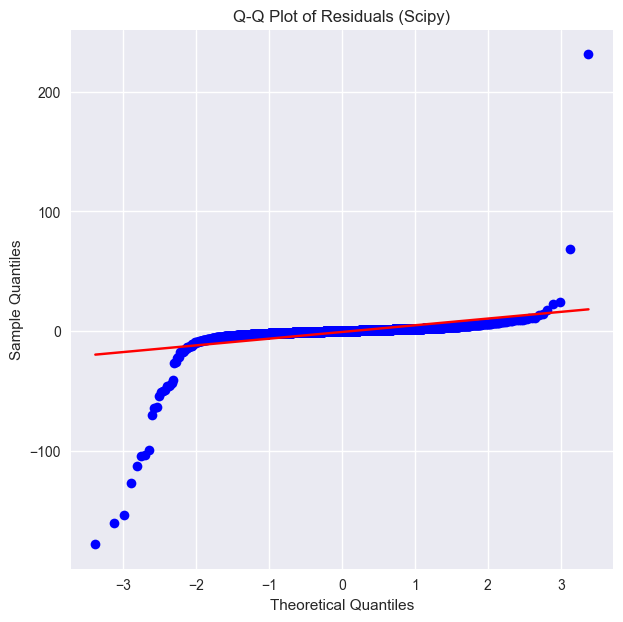

In [52]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Assuming you have the results for your chosen model
chosen_model_results = all_scenario_results['Optuna_FullSet'] # Example
y_test_actual = chosen_model_results['y_test']
y_test_pred = chosen_model_results['y_test_pred']
residuals = y_test_actual - y_test_pred

# Using scipy
plt.figure(figsize=(7, 7))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (Scipy)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.show() # Or save to your PDF / plots fold

In [ ]:
Optuna-Specific Visualizations (if you chose an Optuna model):

In [54]:
import optuna.visualization as vis

# chosen_optuna_results = all_scenario_results['Optuna_FullSet'] # Example
# study = chosen_optuna_results['optimization_results']['study']

if vis.is_available():
    fig1 = vis.plot_optimization_history(study)
    fig1.show()
    fig2 = vis.plot_param_importances(study) # Shows which hyperparameters were most influential
    fig2.show()
    fig3 = vis.plot_slice(study) # Shows how individual hyperparameters affected the objective
    fig3.show()
    # For regression, contour plots might be useful if you have 2-3 dominant hyperparameters
    # fig4 = vis.plot_contour(study, params=['learning_rate', 'max_depth'])
    # fig4.show()

Good Model: If Test RMSE and CV RMSE are acceptable, metrics are stable, feature importances make sense, and diagnostic plots look good, you might have a model ready for further steps (e.g., deployment, more in-depth XAI).
Overfitting: If train RMSE is much lower than validation/test RMSE, the model is overfitting.
Actions: Try stronger regularization (increase reg_alpha, reg_lambda, gamma; decrease max_depth, min_child_weight), get more data, or use more aggressive feature selection (like your Scenario 5). Optuna might have already explored some of these.
Underfitting: If all RMSEs (train, val, test) are high, the model is too simple or not capturing the underlying patterns.
Actions: Try a more complex model (increase n_estimators, max_depth; decrease min_child_weight), ensure important features are not missing, or engineer new features.
Problematic Residuals/Plots: If residual plots show clear patterns or Q-Q plots show significant deviation from normality (and you care about that assumption), it might indicate model misspecification or issues with feature transformations (e.g., the log transform of y might not have been enough, or some X features need transformation).
Unstable CV Scores: If cv_std is very high relative to cv_mean, the model's performance is sensitive to the data split.

In [56]:
import optuna.visualization as vis

# Assuming 'study' is your Optuna study object:
study = all_scenario_results['Optuna_FullSet']['optimization_results']['study'] # Example

if vis.is_available(): # Check if plotly is installed for visualization
    fig = vis.plot_optimization_history(study)
    fig.show() # Or save to file: fig.write_html("optuna_history.html")

In [57]:
if vis.is_available():
    # Plot for a single hyperparameter
    fig_slice_lr = vis.plot_slice(study, params=['learning_rate'])
    fig_slice_lr.show()

    # You can list multiple parameters to see their slices
    fig_slice_multiple = vis.plot_slice(study, params=['max_depth', 'n_estimators', 'subsample'])
    fig_slice_multiple.show()

In [58]:
if vis.is_available():
    fig_parallel = vis.plot_parallel_coordinate(study)
    # You can also select specific parameters:
    # fig_parallel_selected = vis.plot_parallel_coordinate(study, params=['learning_rate', 'max_depth', 'n_estimators'])
    fig_parallel.show()

In [59]:
if vis.is_available():
    fig_importance = vis.plot_param_importances(study)
    fig_importance.show()

In [61]:
results

{'metrics': {'train': {'rmse': nan, 'mae': nan},
  'validation': {'rmse': np.float64(-15.505985625930423), 'mae': nan},
  'test': {'rmse': nan, 'mae': nan, 'r2': 0.9637505057225354}},
 'cv_results': {'cv_mean': np.float64(-15.505985625930423),
  'cv_std': nan,
  'notes': 'score_val from AG leaderboard'},
 'feature_names': ['month_of_argument',
  'month_of_decision',
  'year_of_decision',
  'is_argument_late_in_term',
  'is_decision_late_in_term',
  'court_term_year',
  'natural_court_period',
  'case_docket_type',
  'jurisdiction_type',
  'broad_issue_area',
  'petitioner_type',
  'respondent_type',
  'consolidated_dockets_count',
  'lower_court_disagreement',
  'lower_court_disposition_type',
  'days_term_start_to_argument',
  'days_term_start_to_decision',
  'cert_reason_category',
  'law_type_category',
  'is_govt_vs_business_case',
  'is_individual_vs_govt_case',
  'complexity_score_consolidated_disagree',
  'lower_court_ideological_direction',
  'lower_court_disagree_ideology'],
 

In [68]:
# Assume 'results_optuna_fullset' is the dictionary returned by a successful
# call to trainer.train_model(...) for your Optuna FullSet scenario,
# or any other scenario's results dictionary from 'all_scenario_results'.

#Example:
chosen_model_scenario_name = 'Optuna_FullSet'
if chosen_model_scenario_name in all_scenario_results and all_scenario_results[chosen_model_scenario_name]:
    model_run_results = all_scenario_results[chosen_model_scenario_name]
else:
    print(f"Results for {chosen_model_scenario_name} not found or scenario failed.")
    # Handle error or exit

# For a generic 'model_run_results' object:
if model_run_results: # Check if the results object exists (scenario might have failed)
    if 'y_test' in model_run_results and 'y_test_pred' in model_run_results:
        actual_test_values = model_run_results['y_test']
        predicted_test_values = model_run_results['y_test_pred']

        print(f"Successfully extracted actual and predicted values for the test set.")
        print(f"Number of actual test values: {len(actual_test_values)}")
        print(f"Number of predicted test values: {len(predicted_test_values)}")

        # Now you can use actual_test_values and predicted_test_values for any analysis:
        # For example, calculate residuals manually:
        if len(actual_test_values) == len(predicted_test_values):
            residuals_manual = np.asarray(actual_test_values) - np.asarray(predicted_test_values)
            print(f"Manually calculated residuals (first 5): {residuals_manual[:5]}")
            # You can then plot these, calculate custom error metrics, etc.
        else:
            print("Warning: Length of actual and predicted test values do not match.")

    else:
        print("Error: 'y_test' or 'y_test_pred' keys are missing from the results dictionary.")
        print(f"Available keys are: {model_run_results.keys()}")
else:
    print("Error: The results object itself is None (likely the scenario failed).")

Successfully extracted actual and predicted values for the test set.
Number of actual test values: 1907
Number of predicted test values: 1907
Manually calculated residuals (first 5): [-0.52733994  1.61824036  0.18855286 -1.97088623 -1.42461395]


Plotting the distribution of manually calculated residuals...


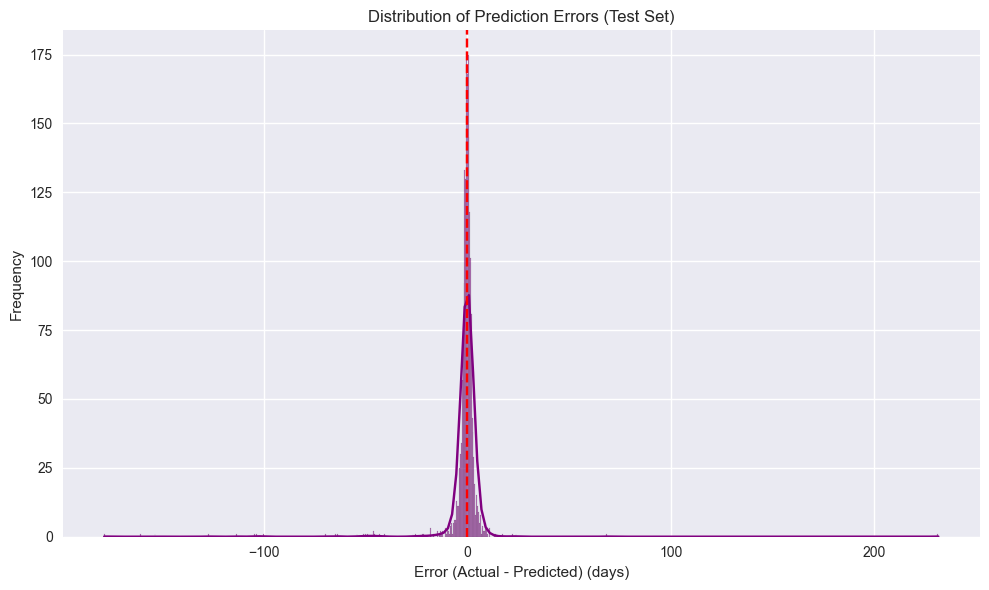

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Ensure numpy is imported if not already

# --- ASSUMPTION ---
# The following variables are already defined and populated from your previous steps:
# actual_test_values: The actual target values for your test set (e.g., model_run_results['y_test'])
# predicted_test_values: The model's predictions on your test set (e.g., model_run_results['y_test_pred'])
# residuals_manual: The difference calculated as np.asarray(actual_test_values) - np.asarray(predicted_test_values)

# Check if residuals_manual was successfully calculated and is not empty
if 'residuals_manual' in locals() and residuals_manual is not None and len(residuals_manual) > 0:
    print("Plotting the distribution of manually calculated residuals...")
    try:
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.histplot(residuals_manual, kde=True, ax=ax, color='purple') # Using purple as in your example image
        ax.axvline(0, color='r', linestyle='--')
        ax.set_title('Distribution of Prediction Errors (Test Set)')
        ax.set_xlabel('Error (Actual - Predicted) (days)')
        ax.set_ylabel('Frequency')
        plt.tight_layout()
        plt.show() # Display the plot

        # If you want to save it to a file (e.g., PNG):
        # plot_save_path = "../plots/manual_residuals_distribution.png" # Define your path
        # os.makedirs(os.path.dirname(plot_save_path), exist_ok=True) # Ensure directory exists
        # fig.savefig(plot_save_path, bbox_inches='tight')
        # print(f"Residual distribution plot saved to: {plot_save_path}")
        # plt.close(fig) # Close the figure after saving if you don't want it to display inline again

    except Exception as e:
        print(f"An error occurred while trying to plot the residuals: {e}")

else:
    print("Could not plot residuals: 'residuals_manual' is not defined, is None, or is empty.")
    print("Please ensure you have successfully extracted y_test, y_test_pred, and calculated residuals_manual.")

In [71]:
import numpy as np
import pandas as pd # For the convenient .describe() method

# --- ASSUMPTION ---
# The following variable is already defined and populated from your previous steps:
# residuals_manual: A NumPy array of the calculated residuals (actual_test_values - predicted_test_values)

if 'residuals_manual' in locals() and residuals_manual is not None and len(residuals_manual) > 0:
    print("\n--- Descriptive Statistics for Model Residuals (Test Set) ---")

    # Using NumPy for individual statistics
    mean_residual = np.mean(residuals_manual)
    median_residual = np.median(residuals_manual)
    std_dev_residual = np.std(residuals_manual)
    min_residual = np.min(residuals_manual)
    max_residual = np.max(residuals_manual)
    
    q25_residual = np.percentile(residuals_manual, 25)
    q75_residual = np.percentile(residuals_manual, 75)
    iqr_residual = q75_residual - q25_residual

    print(f"Mean Residual:              {mean_residual:.4f}")
    print(f"Median Residual:            {median_residual:.4f}")
    print(f"Standard Deviation:         {std_dev_residual:.4f}")
    print(f"Minimum Residual:           {min_residual:.4f}")
    print(f"Maximum Residual:           {max_residual:.4f}")
    print(f"25th Percentile (Q1):       {q25_residual:.4f}")
    print(f"75th Percentile (Q3):       {q75_residual:.4f}")
    print(f"Interquartile Range (IQR):  {iqr_residual:.4f}")

    # For a quick summary, you can also use pandas Series describe()
    print("\n--- Pandas Series describe() output for residuals ---")
    residuals_series = pd.Series(residuals_manual)
    print(residuals_series.describe())

else:
    print("Could not calculate residual statistics: 'residuals_manual' is not defined, is None, or is empty.")


--- Descriptive Statistics for Model Residuals (Test Set) ---
Mean Residual:              -0.8013
Median Residual:            0.0234
Standard Deviation:         11.4720
Minimum Residual:           -178.3426
Maximum Residual:           231.5356
25th Percentile (Q1):       -1.2468
75th Percentile (Q3):       1.2257
Interquartile Range (IQR):  2.4725

--- Pandas Series describe() output for residuals ---
count    1907.000000
mean       -0.801264
std        11.475058
min      -178.342590
25%        -1.246849
50%         0.023392
75%         1.225687
max       231.535583
dtype: float64


In [72]:
import numpy as np
import pandas as pd

# --- ASSUMPTIONS ---
# The following variables are already defined and populated from your previous steps:
# 1. actual_test_values: A NumPy array or Pandas Series of the true 'case_duration_days'
#                        for your test set (e.g., model_run_results['y_test']).
# 2. std_dev_residual: The standard deviation of your residuals, calculated previously
#                      (e.g., std_dev_residual = np.std(residuals_manual)).

if 'actual_test_values' in locals() and actual_test_values is not None and len(actual_test_values) > 0 and \
   'std_dev_residual' in locals() and std_dev_residual is not None:

    print("\n--- Descriptive Statistics for Actual Case Duration Days (Test Set) ---")

    # Using NumPy for individual statistics
    mean_actual_duration = np.mean(actual_test_values)
    median_actual_duration = np.median(actual_test_values)
    std_dev_actual_duration = np.std(actual_test_values)
    min_actual_duration = np.min(actual_test_values)
    max_actual_duration = np.max(actual_test_values)
    
    q25_actual_duration = np.percentile(actual_test_values, 25)
    q75_actual_duration = np.percentile(actual_test_values, 75)
    iqr_actual_duration = q75_actual_duration - q25_actual_duration

    print(f"Mean Duration:              {mean_actual_duration:.2f} days")
    print(f"Median Duration:            {median_actual_duration:.2f} days")
    print(f"Standard Deviation:         {std_dev_actual_duration:.2f} days")
    print(f"Minimum Duration:           {min_actual_duration:.2f} days")
    print(f"Maximum Duration:           {max_actual_duration:.2f} days")
    print(f"25th Percentile (Q1):       {q25_actual_duration:.2f} days")
    print(f"75th Percentile (Q3):       {q75_actual_duration:.2f} days")
    print(f"Interquartile Range (IQR):  {iqr_actual_duration:.2f} days")

    # For a quick summary using pandas Series describe()
    print("\n--- Pandas Series describe() output for actual case duration days (Test Set) ---")
    actual_duration_series = pd.Series(actual_test_values)
    print(actual_duration_series.describe().round(2))

    # --- Percentage-wise comparison ---
    # This is effectively the Coefficient of Variation of the errors relative to the mean of the target
    if mean_actual_duration != 0: # Avoid division by zero
        relative_std_dev_of_error = (std_dev_residual / mean_actual_duration) * 100
        print(f"\n--- Contextual Error Metric ---")
        print(f"Standard Deviation of Residuals: {std_dev_residual:.2f} days")
        print(f"Mean Actual Case Duration:         {mean_actual_duration:.2f} days")
        print(f"Residual Std Dev as a Percentage of Mean Duration: {relative_std_dev_of_error:.2f}%")
    else:
        print("\nMean actual duration is zero, cannot calculate relative percentage for error std dev.")

else:
    print("Could not calculate statistics for actual durations: 'actual_test_values' or 'std_dev_residual' is not defined, is None, or is empty.")


--- Descriptive Statistics for Actual Case Duration Days (Test Set) ---
Mean Duration:              90.46 days
Median Duration:            75.00 days
Standard Deviation:         63.68 days
Minimum Duration:           0.00 days
Maximum Duration:           693.00 days
25th Percentile (Q1):       53.00 days
75th Percentile (Q3):       112.00 days
Interquartile Range (IQR):  59.00 days

--- Pandas Series describe() output for actual case duration days (Test Set) ---
count    1907.00
mean       90.46
std        63.70
min         0.00
25%        53.00
50%        75.00
75%       112.00
max       693.00
Name: case_duration_days, dtype: float64

--- Contextual Error Metric ---
Standard Deviation of Residuals: 11.47 days
Mean Actual Case Duration:         90.46 days
Residual Std Dev as a Percentage of Mean Duration: 12.68%


In [74]:
y.mean()

np.float64(92.70820222362073)

In [ ]:
optuna_search_space_xgb2 = {'n_estimators': {'type': 'int', 'low': 500, 'high': 3500},
 'learning_rate': {'type': 'float', 'low': 0.005, 'high': 0.1, 'log': True},
 'max_depth': {'type': 'int', 'low': 4, 'high': 12},
 'subsample': {'type': 'float', 'low': 0.5, 'high': 1.0},
 'colsample_bytree': {'type': 'float', 'low': 0.5, 'high': 1.0},
 'gamma': {'type': 'float', 'low': 1e-08, 'high': 1.0, 'log': True},
 'min_child_weight': {'type': 'int', 'low': 4, 'high': 20},
 'reg_lambda': {'type': 'float', 'low': 1e-08, 'high': 20.0, 'log': True},
 'reg_alpha': {'type': 'float', 'low': 1e-08, 'high': 20.0, 'log': True}}

In [ ]:
loginputs['y']

0       313.0
1       404.0
2       404.0
3       404.0
4       404.0
        ...  
9529     64.0
9530     64.0
9531     67.0
9532    126.0
9533    126.0
Name: case_duration_days, Length: 9534, dtype: float64

In [ ]:
    current_y = inputs['y']

In [79]:
# Assume 'trainer' is your instantiated XGBoostModelTrainer
# Assume 'all_model_inputs' is populated from your preprocessing script
# Assume 'optuna_search_space_xgb' is defined (as in your previous scenario script)

# Name for this specific model run
model_run_name = 'Optuna_On_FullSet2222'
feature_set_to_use = 'FullSet' # Key from your all_model_inputs dictionary

if feature_set_to_use in all_model_inputs:
    print(f"\n" + "="*80)
    print(f"TRAINING SCENARIO: {model_run_name.upper()}")
    print(f"Using feature set: {feature_set_to_use}")
    print("Optimization: Optuna")
    print("="*80)

    # Get the specific inputs for the chosen feature set
    inputs = all_model_inputs[feature_set_to_use]
    current_X = inputs['X']
    original_y = inputs['y'] #current_y = inputs['y']
    current_num_for_trainer = inputs['numerical_for_trainer']
    current_cat_for_trainer = inputs['categorical_for_trainer']

    # --- Log-transform the target variable ---
    current_y_log_transformed = np.log1p(original_y)
    print(f"Original y skewness: {original_y.skew():.2f}")
    print(f"Log-transformed y skewness: {current_y_log_transformed.skew():.2f}")

    # Define Optuna parameters
    optuna_params_for_run = {
        'n_trials': 100,  # Or your desired number of trials
        'timeout': 1200, # Or your desired timeout in seconds (e.g., 1200s = 20 minutes)
        'search_space': optuna_search_space_xgb2 # Your predefined search space
    }

    start_time = time.time()
    results_optuna_fullset = trainer.train_model(
        X=current_X,
        y=current_y_log_transformed,
        numerical_features=current_num_for_trainer,
        categorical_features=current_cat_for_trainer,
        model_name=f'scdb_duration_{feature_set_to_use}_optuna_single_run', # Unique model name
        optimization_method='optuna',
        optimization_params=optuna_params_for_run,
        early_stopping_rounds=50, # For the final model training after HPO
        create_plots=True,
        perform_cv=True,       # Perform CV on the best HPO parameters
        cv_folds=5,            # Number of CV folds
        advanced_cv=True       # Use advanced CV if early stopping is involved
    )
    run_time = time.time() - start_time

    print(f"\nTraining for {model_run_name} completed in {run_time/60:.1f} minutes.")
    if results_optuna_fullset:
        if results_optuna_fullset.get('optimization_results', {}).get('best_params'):
            print(f"Best parameters found by Optuna: {results_optuna_fullset['optimization_results']['best_params']}")
        if results_optuna_fullset.get('metrics', {}).get('test'):
            print(f"Test RMSE: {results_optuna_fullset['metrics']['test']['rmse']:.2f} days")
        if results_optuna_fullset.get('cv_results') and 'cv_mean' in results_optuna_fullset['cv_results']:
            print(f"CV RMSE on best params: {results_optuna_fullset['cv_results']['cv_mean']:.2f} ± {results_optuna_fullset['cv_results']['cv_std']:.2f}")
        
        # You can add this result to your all_scenario_results if you're collecting them
        all_scenario_results[model_run_name] = results_optuna_fullset
    else:
        print(f"Training for {model_run_name} did not produce results.")

else:
    print(f"Error: Feature set '{feature_set_to_use}' not found in all_model_inputs.")


TRAINING SCENARIO: OPTUNA_ON_FULLSET2222
Using feature set: FullSet
Optimization: Optuna
Original y skewness: 3.28
Log-transformed y skewness: -0.61
Starting Enhanced XGBoost Training Pipeline
Device: CUDA
CUDA Devices: 3
Model name: scdb_duration_FullSet_optuna_single_run_v3
Model directory: ../models\scdb_duration_FullSet_optuna_single_run_v3
Creating data splits...
Data splits created:
   Train: 6482 samples (68.0%)
   Validation: 1145 samples (12.0%)
   Test: 1907 samples (20.0%)
Creating preprocessing pipeline...
Preprocessor created for 21 numerical and 13 categorical features
Fitting preprocessor...
Preprocessing complete: 102 features
Starting Optuna optimization with 100 trials (max 1200s)...
Using custom search space provided from the notebook.


  0%|          | 0/100 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 0.0539

Performing 5-fold cross-validation...
Performing advanced 5-fold cross-validation with early stopping support...
  Fold 1/5
    Fold 1 RMSE: 0.0842
  Fold 2/5
    Fold 2 RMSE: 0.0705
  Fold 3/5
    Fold 3 RMSE: 0.0985
  Fold 4/5
    Fold 4 RMSE: 0.1000
  Fold 5/5
    Fold 5 RMSE: 0.0638
Advanced CV RMSE: 0.08 ± 0.01
Average best iteration: 1082

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 1089
  learning_rate: 0.008889717415801975
  max_depth: 7
  subsample: 0.6725095243788426
  colsample_bytree: 0.9994347571837482
  gamma: 0.00014295925539721343
  min_child_weight: 1
  reg_lambda: 0.011793246872584859
  reg_alpha: 0.007792865036829258
  early_stopping_rounds: 50

Training in progress...

Evaluating model performance...

PERFORMANCE METRICS:
--------------------------------------------------
       TRAI

Approximation to Percentage Error: When RMSE_log is relatively small (e.g., < 0.2-0.3), it can be approximately interpreted in terms of relative (or percentage) error on the original scale.
log(y_actual) - log(y_predicted) = log(y_actual / y_predicted)
So, y_actual / y_predicted ≈ exp(±RMSE_log).
If RMSE_log = 0.1:
exp(0.1) ≈ 1.105 (actual could be ~10.5% higher than predicted)
exp(-0.1) ≈ 0.905 (actual could be ~9.5% lower than predicted)
So, an RMSE_log of 0.1 suggests your predictions are typically within roughly a ±10% multiplicative factor of the actual values.
This is an approximation. The relationship isn't perfectly symmetric for larger log errors.
Why Back-Transformation is Crucial for Business Metrics:

Stakeholders understand original units: People understand "the prediction was off by 15 days" much better than "the log-scale RMSE was 0.15."
Fair Comparison: To compare a model trained on log(y) with a model trained on y, you must evaluate both on the original scale of y.
How to do it:
Get your log-scale predictions: y_pred_log = model.predict(X_test_processed).
Back-transform them: y_pred_original_scale = np.expm1(y_pred_log) (if you used np.log1p(y) for training) or y_pred_original_scale = np.exp(y_pred_log) (if you used np.log(y)).
Get your actual test values on the original scale: y_test_original_scale_actual. (Your script already handles getting this correctly using test indices).
Calculate metrics like RMSE and MAE using these original scale values:

In [ ]:
rmse_original = np.sqrt(mean_squared_error(y_test_original_scale_actual, y_test_original_scale_pred))
mae_original = mean_absolute_error(y_test_original_scale_actual, y_test_original_scale_pred)

In [ ]:
# Assume 'trainer' is your instantiated XGBoostModelTrainer
# Assume 'all_model_inputs' is populated from your preprocessing script
# Assume 'optuna_search_space_xgb' is defined.
# If 'optuna_search_space_xgb2' is different, ensure it's defined. For this example, using optuna_search_space_xgb.

# Imports needed for this specific block if not already at the top of your script
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time # Assuming time is used for timing the run

# --- (Your existing script to define all_model_inputs, trainer, optuna_search_space_xgb) ---
# For example:
# if 'trainer' not in locals(): trainer = XGBoostModelTrainer()
# if 'all_model_inputs' not in locals(): # You'd typically load this or run preprocessing
#     print("Error: all_model_inputs not found!")
#     exit()
# if 'optuna_search_space_xgb' not in locals(): # Define if not present
#    optuna_search_space_xgb = {
#        'n_estimators': {'type': 'int', 'low': 500, 'high': 2500},
#        'learning_rate': {'type': 'float', 'low': 0.005, 'high': 0.1, 'log': True},
#         # ... other parameters from your definition
#    }
# if 'all_scenario_results' not in locals(): all_scenario_results = {}


# Name for this specific model run
model_run_name = 'Optuna_LogTarget_FullSet_Single' # Made name more descriptive
feature_set_to_use = 'FullSet' # Key from your all_model_inputs dictionary

if feature_set_to_use in all_model_inputs:
    print(f"\n" + "="*80)
    print(f"TRAINING SCENARIO: {model_run_name.upper()}")
    print(f"Using feature set: {feature_set_to_use}")
    print("Target Transformation: Log1p(y)")
    print("Optimization: Optuna")
    print("="*80)

    inputs = all_model_inputs[feature_set_to_use]
    current_X = inputs['X']
    original_y = inputs['y'] # This is y on its original scale
    current_num_for_trainer = inputs['numerical_for_trainer']
    current_cat_for_trainer = inputs['categorical_for_trainer']

    current_y_log_transformed = np.log1p(original_y)
    print(f"Original y skewness: {original_y.skew():.2f}")
    print(f"Log-transformed y skewness: {current_y_log_transformed.skew():.2f}")

    optuna_params_for_run = {
        'n_trials': 100,
        'timeout': 1200,
        'search_space': optuna_search_space_xgb # Using the primary one, ensure optuna_search_space_xgb2 is defined if different
    }

    start_time = time.time()
    results_optuna_logtarget = trainer.train_model( # Renamed results variable for clarity
        X=current_X,
        y=current_y_log_transformed, # Pass log-transformed y
        numerical_features=current_num_for_trainer,
        categorical_features=current_cat_for_trainer,
        model_name=f'scdb_duration_{feature_set_to_use}_optuna_log_single',
        optimization_method='optuna',
        optimization_params=optuna_params_for_run,
        early_stopping_rounds=50,
        create_plots=True,
        perform_cv=True,
        cv_folds=5,
        advanced_cv=True
    )
    run_time = time.time() - start_time

    print(f"\nTraining for {model_run_name} completed in {run_time/60:.1f} minutes.")

    if results_optuna_logtarget:
        # --- Initial Results (on log scale as returned by trainer) ---
        if results_optuna_logtarget.get('optimization_results', {}).get('best_params'):
            print(f"\nBest parameters found by Optuna (for log-transformed target):")
            # Print only Optuna-tuned params for brevity
            optuna_tuned_params = results_optuna_logtarget['model_metadata']['model_params']
            for param_key in optuna_search_space_xgb.keys(): # Iterate through keys defined in search space
                if param_key in optuna_tuned_params:
                    print(f"  {param_key}: {optuna_tuned_params[param_key]}")

        metrics_log_scale_test = results_optuna_logtarget.get('metrics', {}).get('test', {})
        print(f"\nTest RMSE (log-scale, from trainer): {metrics_log_scale_test.get('rmse', np.nan):.4f}")

        cv_results_log_scale = results_optuna_logtarget.get('cv_results')
        if cv_results_log_scale and 'cv_mean' in cv_results_log_scale:
            print(f"CV RMSE on best params (log-scale, from trainer): {cv_results_log_scale['cv_mean']:.4f} +/- {cv_results_log_scale.get('cv_std', np.nan):.4f}")

        # --- Calculate and Print Metrics on Normal (Original) Scale ---
        # y_test from results is the log-transformed y for the test split
        y_test_log_pred = results_optuna_logtarget.get('y_test_pred')

        # To get the *actual* y_test values on the original scale, we use the original_y
        # and the indices from X_test_original (which the trainer stores)
        X_test_original_df = results_optuna_logtarget.get('X_test_original')

        if y_test_log_pred is not None and X_test_original_df is not None:
            test_indices = X_test_original_df.index
            y_test_original_scale_actual = original_y.loc[test_indices]

            # Back-transform predictions
            y_test_original_scale_pred = np.expm1(y_test_log_pred)

            # Calculate metrics on original scale
            rmse_original = np.sqrt(mean_squared_error(y_test_original_scale_actual, y_test_original_scale_pred))
            mae_original = mean_absolute_error(y_test_original_scale_actual, y_test_original_scale_pred)
            r2_original = r2_score(y_test_original_scale_actual, y_test_original_scale_pred)

            print("\n--- Performance on Test Set (ORIGINAL SCALE) ---")
            print(f"  Test RMSE (original scale): {rmse_original:.2f} days")
            print(f"  Test MAE (original scale):  {mae_original:.2f} days")
            print(f"  Test R² (original scale):   {r2_original:.4f}")

            # Optionally, store these original scale metrics back into the results dictionary
            results_optuna_logtarget['metrics_original_scale'] = {
                'rmse': rmse_original,
                'mae': mae_original,
                'r2': r2_original
            }
        else:
            print("\nCould not calculate metrics on original scale: y_test_pred or X_test_original missing from results.")
        
        # Add to your main results dictionary if you have one
        if 'all_scenario_results' in locals():
            all_scenario_results[model_run_name] = results_optuna_logtarget
    else:
        print(f"Training for {model_run_name} did not produce results.")
else:
    print(f"Error: Feature set '{feature_set_to_use}' not found in all_model_inputs.")

In [80]:
display(results)

{'metrics': {'train': {'rmse': nan, 'mae': nan},
  'validation': {'rmse': np.float64(-15.505985625930423), 'mae': nan},
  'test': {'rmse': nan, 'mae': nan, 'r2': 0.9637505057225354}},
 'cv_results': {'cv_mean': np.float64(-15.505985625930423),
  'cv_std': nan,
  'notes': 'score_val from AG leaderboard'},
 'feature_names': ['month_of_argument',
  'month_of_decision',
  'year_of_decision',
  'is_argument_late_in_term',
  'is_decision_late_in_term',
  'court_term_year',
  'natural_court_period',
  'case_docket_type',
  'jurisdiction_type',
  'broad_issue_area',
  'petitioner_type',
  'respondent_type',
  'consolidated_dockets_count',
  'lower_court_disagreement',
  'lower_court_disposition_type',
  'days_term_start_to_argument',
  'days_term_start_to_decision',
  'cert_reason_category',
  'law_type_category',
  'is_govt_vs_business_case',
  'is_individual_vs_govt_case',
  'complexity_score_consolidated_disagree',
  'lower_court_ideological_direction',
  'lower_court_disagree_ideology'],
 

In [81]:
# --- Add the results of the specific Optuna Log-Transformed run ---
if model_run_name in all_scenario_results and all_scenario_results[model_run_name]:
    results = all_scenario_results[model_run_name]
    name = model_run_name # Use the specific name for the 'Model' column

    model_entry = {'Model': name}

    # Extract metrics
    metrics_dict = results.get('metrics', {})
    train_metrics = metrics_dict.get('train', {})       # These are on log scale
    val_metrics = metrics_dict.get('validation', {})   # These are on log scale
    
    # Use original scale metrics if available, otherwise use log-scale test metrics
    if 'metrics_original_scale' in results:
        test_metrics_to_use = results['metrics_original_scale']
        scale_note = "" # Empty note for original scale
    else:
        test_metrics_to_use = metrics_dict.get('test', {}) # Fallback to log-scale test metrics
        scale_note = " (log-scale)"

    model_entry['Train RMSE'] = f"{train_metrics.get('rmse', np.nan):.4f} (log)"
    model_entry['Train MAE'] = f"{train_metrics.get('mae', np.nan):.4f} (log)"
    model_entry['Val RMSE'] = f"{val_metrics.get('rmse', np.nan):.4f} (log)"
    model_entry['Val MAE'] = f"{val_metrics.get('mae', np.nan):.4f} (log)"
    
    model_entry['Test RMSE'] = test_metrics_to_use.get('rmse', np.nan) # Already formatted if string
    model_entry['Test MAE'] = test_metrics_to_use.get('mae', np.nan)
    model_entry['Test R²'] = test_metrics_to_use.get('r2', np.nan)
    if scale_note and isinstance(model_entry['Test RMSE'], (float, int)): # Add note if it's numeric and log
        model_entry['Test RMSE'] = f"{model_entry['Test RMSE']:.4f}{scale_note}"


    # CV Results (these are on log scale as per trainer's Optuna objective)
    cv_res_dict = results.get('cv_results')
    if cv_res_dict and 'cv_mean' in cv_res_dict:
        cv_mean = cv_res_dict['cv_mean']
        cv_std = cv_res_dict.get('cv_std', np.nan)
        model_entry['CV RMSE'] = f"{cv_mean:.4f} +/- {cv_std:.4f} (log-scale)" if not pd.isna(cv_std) else f"{cv_mean:.4f} (log-scale)"
    else:
        model_entry['CV RMSE'] = 'N/A'

    # Feature counts
    model_meta = results.get('model_metadata', {})
    model_entry['Features'] = len(results.get('feature_names', []))
    model_entry['Original Features Used'] = model_meta.get('data_info', {}).get('n_features_original', 'N/A')
    model_entry['Train Time (s)'] = model_meta.get('training_duration_seconds', np.nan)


    # Model Parameters
    model_params_from_metadata = model_meta.get('model_params', {})
    if not isinstance(model_params_from_metadata, dict): model_params_from_metadata = {}

    # Ensure sorted_param_names is defined. If not, create a basic one for this entry.
    if 'sorted_param_names' not in locals():
        sorted_param_names = sorted(list(model_params_from_metadata.keys()))
        if 'Autogluon Best Model Params' in results: # Handle special AG case
            if 'Autogluon Best Model Params' not in sorted_param_names:
                 sorted_param_names.append('Autogluon Best Model Params')


    for param_name in sorted_param_names:
        if param_name == 'Autogluon Best Model Params': # Specific handling for AG string
            model_entry[param_name] = results.get(param_name, np.nan)
        else:
            model_entry[param_name] = model_params_from_metadata.get(param_name, np.nan)
    
    # Append the new model's data to your main list
    if 'comparison_data' in locals() and isinstance(comparison_data, list):
        comparison_data.append(model_entry)
        print(f"\nResults for '{name}' added to comparison_data list.")

        # --- Regenerate and display the updated comparison DataFrame ---
        # This part assumes the rest of your comparison table generation logic is available
        # For a quick view, we'll just recreate it here.
        
        comparison_df_updated = pd.DataFrame(comparison_data)

        # Define column order (ensure 'Train Time (s)' is included)
        metric_cols_ordered_updated = [
            'Model', 'Train Time (s)', 'Train RMSE', 'Train MAE', 'Val RMSE', 'Val MAE',
            'Test RMSE', 'Test MAE', 'Test R²', 'CV RMSE',
            'Features', 'Original Features Used'
        ]
        final_metric_cols_updated = [col for col in metric_cols_ordered_updated if col in comparison_df_updated.columns]
        final_param_cols_updated = [col for col in sorted_param_names if col in comparison_df_updated.columns]
        
        final_column_order_updated = final_metric_cols_updated + final_param_cols_updated
        # Add any other columns that might have been created but not in the defined order
        other_cols = [col for col in comparison_df_updated.columns if col not in final_column_order_updated]
        final_column_order_updated.extend(other_cols)

        comparison_df_updated = comparison_df_updated.reindex(columns=final_column_order_updated)

        if 'Test RMSE' in comparison_df_updated.columns:
            def get_sort_key(val):
                if isinstance(val, str):
                    match = re.match(r"([0-9\.]+)", val)
                    return float(match.group(1)) if match else float('inf')
                return float('inf') if pd.isna(val) else float(val)
            comparison_df_updated['sort_Test_RMSE'] = comparison_df_updated['Test RMSE'].apply(get_sort_key)
            comparison_df_sorted_updated = comparison_df_updated.sort_values(
                by='sort_Test_RMSE', ascending=True, na_position='last'
            ).drop(columns=['sort_Test_RMSE'])
        else:
            comparison_df_sorted_updated = comparison_df_updated.copy()

        # Format numerical metric columns for display
        for col in ['Train Time (s)', 'Train RMSE', 'Train MAE', 'Val RMSE', 'Val MAE', 'Test RMSE', 'Test MAE', 'Test R²']:
            if col in comparison_df_sorted_updated.columns:
                comparison_df_sorted_updated[col] = comparison_df_sorted_updated[col].apply(
                    lambda x: f"{x:.2f}" if isinstance(x, (int, float)) and not pd.isna(x) and not isinstance(x, str) # Avoid re-formatting strings
                              else (f"{float(re.match(r'([0-9\.]+)', x).group(1)):.4f} (log)" if isinstance(x, str) and '(log)' in x # Keep log format
                                    else x) # Keep other strings as is
                )
        
        print("\n--- UPDATED FINAL RESULTS COMPARISON (DETAILED) ---")
        print(comparison_df_sorted_updated.to_string(index=False))

    else:
        print("Error: 'comparison_data' list not found or not a list. Cannot append results.")
else:
    print(f"Results for model '{model_run_name}' not found in all_scenario_results or scenario failed.")



Results for 'Optuna_On_FullSet2222' added to comparison_data list.

--- UPDATED FINAL RESULTS COMPARISON (DETAILED) ---
                              Model Train Time (s)   Train RMSE    Train MAE     Val RMSE      Val MAE          Test RMSE Test MAE Test R²                                  CV RMSE  Features  Original Features Used  n_estimators  learning_rate  max_depth  min_child_weight  subsample  colsample_bytree    gamma  reg_alpha  reg_lambda        objective tree_method  random_state  early_stopping_rounds  scale_pos_weight                                                                                         Autogluon Best Model Params allow_writing_files eval_metric  gpu_id  iterations  n_jobs     predictor  random_seed
              Optuna_On_FullSet2222         513.23 0.0143 (log) 0.0093 (log) 0.0539 (log) 0.0164 (log) 0.0845 (log-scale)     0.02    0.98            0.0834 +/- 0.0145 (log-scale)       102                      34        1089.0       0.008890        7.0      

In [83]:
# =============================================================================
# RESULTS COMPARISON (using all_scenario_results)
# (Ensures Test Metrics are on Original Scale for Log-Transformed Models)
# =============================================================================
print("\n" + "="*70)
print("FINAL RESULTS COMPARISON (DETAILED)")
print("="*70)

comparison_data = []
all_param_names_collected = set() # To collect all unique parameter names

# First pass to collect all parameter names (your existing logic for this is good)
for name_key, results_item_loop in all_scenario_results.items():
    if results_item_loop:
        model_meta_loop = results_item_loop.get('model_metadata', {})
        if model_meta_loop.get('model_params'):
            model_params_dict_for_keys = model_meta_loop.get('model_params', {})
            if isinstance(model_params_dict_for_keys, dict):
                all_param_names_collected.update(model_params_dict_for_keys.keys())
        if 'Autogluon Best Model Params' in results_item_loop: # If you have this specific column
            all_param_names_collected.add('Autogluon Best Model Params')

common_xgb_params = [ # Define your preferred order of common params
    'n_estimators', 'learning_rate', 'max_depth', 'min_child_weight',
    'subsample', 'colsample_bytree', 'gamma', 'reg_alpha', 'reg_lambda',
    'objective', 'tree_method', 'random_state', 'early_stopping_rounds', 'scale_pos_weight'
]
if 'Autogluon Best Model Params' in all_param_names_collected:
    common_xgb_params.append('Autogluon Best Model Params')
sorted_param_names = [p for p in common_xgb_params if p in all_param_names_collected]
sorted_param_names += sorted([p for p in all_param_names_collected if p not in common_xgb_params])


for name, results in all_scenario_results.items(): # Iterate through your collected results
    if not results:
        model_entry = {'Model': name, 'Test RMSE': np.nan, 'Train Time (s)': np.nan}
        for param_name_loop in sorted_param_names: model_entry[param_name_loop] = np.nan
        comparison_data.append(model_entry)
        continue

    model_entry = {'Model': name}
    metrics_dict = results.get('metrics', {})
    train_metrics = metrics_dict.get('train', {})
    val_metrics = metrics_dict.get('validation', {})
    # Default to test metrics from the main 'metrics' key
    test_metrics_to_use = metrics_dict.get('test', {})
    scale_note_test_rmse = "" # Note for Test RMSE if it's log scale

    model_meta = results.get('model_metadata', {})
    model_entry['Train Time (s)'] = model_meta.get('training_duration_seconds', np.nan)

    # --- MODIFICATION FOR TEST METRICS ON ORIGINAL SCALE ---
    if 'metrics_original_scale' in results: # Check if back-transformed metrics exist
        test_metrics_to_use = results['metrics_original_scale']
        # Train/Val metrics are still from the log-scale training
        model_entry['Train RMSE'] = f"{train_metrics.get('rmse', np.nan):.4f} (log)"
        model_entry['Train MAE'] = f"{train_metrics.get('mae', np.nan):.4f} (log)"
        model_entry['Val RMSE'] = f"{val_metrics.get('rmse', np.nan):.4f} (log)"
        model_entry['Val MAE'] = f"{val_metrics.get('mae', np.nan):.4f} (log)"
    else: # For models not trained on log-y, or if back-transformation wasn't done/stored
        model_entry['Train RMSE'] = train_metrics.get('rmse', np.nan)
        model_entry['Train MAE'] = train_metrics.get('mae', np.nan)
        model_entry['Val RMSE'] = val_metrics.get('rmse', np.nan)
        model_entry['Val MAE'] = val_metrics.get('mae', np.nan)
        # If 'metrics_original_scale' is not present, and it's a log model, the test RMSE is log.
        if name.startswith('LogTarget_') or name.startswith('Optuna_LogTarget_'): # Heuristic for log models
            scale_note_test_rmse = " (log-scale)"
    # --- END MODIFICATION ---

    model_entry['Test RMSE'] = test_metrics_to_use.get('rmse', np.nan)
    # Append scale note if Test RMSE is numeric and scale_note_test_rmse is set
    if isinstance(model_entry['Test RMSE'], (float, int)) and scale_note_test_rmse:
        model_entry['Test RMSE'] = f"{model_entry['Test RMSE']:.4f}{scale_note_test_rmse}"
        
    model_entry['Test MAE'] = test_metrics_to_use.get('mae', np.nan)
    model_entry['Test R²'] = test_metrics_to_use.get('r2', np.nan)


    cv_res_dict = results.get('cv_results')
    if cv_res_dict and 'cv_mean' in cv_res_dict:
        cv_mean = cv_res_dict['cv_mean']
        cv_std = cv_res_dict.get('cv_std', np.nan)
        notes = cv_res_dict.get('notes', '')
        suffix = f" ({notes})" if notes else ""
        # For log-trained models, CV is done on log-scale y
        if name.startswith('LogTarget_') or name.startswith('Optuna_LogTarget_') or \
           (name.startswith('Autogluon') and isinstance(cv_mean, float) and cv_mean < 1.0 and not notes):
             suffix = " (log scale?)" + suffix
        model_entry['CV RMSE'] = f"{cv_mean:.4f} +/- {cv_std:.4f}{suffix}" if not pd.isna(cv_std) else f"{cv_mean:.4f}{suffix}"
    else:
        model_entry['CV RMSE'] = 'N/A'

    model_entry['Features'] = len(results.get('feature_names', []))
    model_entry['Original Features Used'] = model_meta.get('data_info', {}).get('n_features_original', 'N/A')

    model_params_from_metadata = model_meta.get('model_params', {})
    if not isinstance(model_params_from_metadata, dict): model_params_from_metadata = {}
    for param_name_loop in sorted_param_names: # Use a different loop variable name
        if param_name_loop == 'Autogluon Best Model Params':
            model_entry[param_name_loop] = results.get(param_name_loop, np.nan)
        else:
            model_entry[param_name_loop] = model_params_from_metadata.get(param_name_loop, np.nan)
    comparison_data.append(model_entry)

# --- (The rest of your DataFrame creation, column ordering, sorting, formatting, and printing logic) ---
# Ensure your formatting loop for numeric columns handles the Test RMSE which should now be mostly numeric
# (except for actual 'N/A' or fallback log-scale strings)

comparison_df = pd.DataFrame(comparison_data)
metric_cols_ordered = [
    'Model', 'Train Time (s)', 'Train RMSE', 'Train MAE', 'Val RMSE', 'Val MAE',
    'Test RMSE', 'Test MAE', 'Test R²', 'CV RMSE',
    'Features', 'Original Features Used'
]
final_metric_cols = [col for col in metric_cols_ordered if col in comparison_df.columns]
final_param_cols = [col for col in sorted_param_names if col in comparison_df.columns]
final_column_order = final_metric_cols + final_param_cols
existing_df_cols = [col for col in comparison_df.columns if col not in final_column_order]
final_column_order.extend(existing_df_cols) # Add any other columns (like new params)
comparison_df = comparison_df.reindex(columns=final_column_order)

if 'Test RMSE' in comparison_df.columns:
    def get_sort_key(val): # This function helps sort mixed type columns (numbers and strings like "value (log)")
        if isinstance(val, str):
            match = re.match(r"([0-9\.]+)", val) # Extracts leading number from string
            return float(match.group(1)) if match else float('inf') # Sort strings without numbers last
        return float('inf') if pd.isna(val) else float(val) # Sort NaNs last

    comparison_df['sort_Test_RMSE'] = comparison_df['Test RMSE'].apply(get_sort_key)
    comparison_df_sorted = comparison_df.sort_values(
        by='sort_Test_RMSE', ascending=True, na_position='last'
    ).drop(columns=['sort_Test_RMSE'])
else:
    comparison_df_sorted = comparison_df.copy()

# Format numerical metric columns for display
for col in ['Train Time (s)', 'Train RMSE', 'Train MAE', 'Val RMSE', 'Val MAE', 'Test RMSE', 'Test MAE', 'Test R²']:
    if col in comparison_df_sorted.columns:
        # Preserve strings (like those with "(log)") and format floats
        def format_value(x):
            if isinstance(x, str): # If already a string (e.g., "0.1234 (log)")
                return x
            if isinstance(x, (int, float)) and not pd.isna(x):
                return f"{x:.2f}" # Standard 2 decimal for original scale, adjust if needed
            return x # Keep NaNs or other types as is
        comparison_df_sorted[col] = comparison_df_sorted[col].apply(format_value)

print(comparison_df_sorted.to_string(index=False))

# ... (rest of your "Best model" printout and CSV saving)


FINAL RESULTS COMPARISON (DETAILED)
                              Model Train Time (s)   Train RMSE    Train MAE     Val RMSE      Val MAE Test RMSE Test MAE Test R²                                  CV RMSE  Features  Original Features Used  n_estimators  learning_rate  max_depth  min_child_weight  subsample  colsample_bytree    gamma  reg_alpha  reg_lambda        objective tree_method  random_state  early_stopping_rounds  scale_pos_weight                                                                                         Autogluon Best Model Params allow_writing_files eval_metric  gpu_id  iterations  n_jobs     predictor  random_seed
              Optuna_On_FullSet2222         513.23         0.01         0.01         0.05         0.02      0.08     0.02    0.98                        0.0834 +/- 0.0145       102                      34        1089.0       0.008890        7.0               1.0    0.67251          0.999435 0.000143   0.007793    0.011793 reg:squarederror    gpu_hist

In [84]:
# =============================================================================
# SINGLE OPTUNA RUN ON FULL FEATURE SET (ORIGINAL Y-SCALE)
# =============================================================================
import pandas as pd
import numpy as np
import time
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Prerequisite: Ensure these are loaded/defined from your main setup ---
# Example (ensure these are defined from your preprocessing script before this script runs):
# if 'trainer' not in locals(): trainer = XGBoostModelTrainer() # Your trainer instance
# if 'all_model_inputs' not in locals(): # You'd typically load this or run preprocessing
#     print("Error: all_model_inputs not found! Please run preprocessing.")
#     exit()
# if 'optuna_search_space_xgb' not in locals(): # Define if not present
#    optuna_search_space_xgb = {
#        'n_estimators': {'type': 'int', 'low': 500, 'high': 2500},
#        # ... other parameters from your definition
#    }
# if 'all_scenario_results' not in locals(): # To store results if you run multiple single scripts
#    all_scenario_results = {}
# --- End Prerequisites ---


# --- Configuration for this Single Run ---
feature_set_key_orig = 'FullSet'
model_run_name_orig = f'Optuna_OriginalY_{feature_set_key_orig}'
optuna_trials_orig = 75  # Adjust as needed
optuna_timeout_orig = 1800 # Adjust as needed (e.g., 30 minutes)
final_cv_folds_orig = 5    # Adjust as needed

print(f"\n" + "="*80)
print(f"RUNNING SINGLE MODEL SCENARIO: {model_run_name_orig.upper()}")
print(f"Using feature set: {feature_set_key_orig}")
print(f"Target: Original case_duration_days")
print(f"Optimization: Optuna ({optuna_trials_orig} trials, timeout {optuna_timeout_orig/60:.0f}m)")
print("="*80)

if feature_set_key_orig in all_model_inputs:
    inputs_orig = all_model_inputs[feature_set_key_orig]
    current_X_orig = inputs_orig['X']
    current_y_orig = inputs_orig['y'] # Using the original y
    current_num_for_trainer_orig = inputs_orig['numerical_for_trainer']
    current_cat_for_trainer_orig = inputs_orig['categorical_for_trainer']

    optuna_params_for_run_orig = {
        'n_trials': optuna_trials_orig,
        'timeout': optuna_timeout_orig,
        'search_space': optuna_search_space_xgb # Your predefined Optuna search space
    }

    start_time = time.time()
    results_optuna_original_y = trainer.train_model(
        X=current_X_orig,
        y=current_y_orig, # Pass original y
        numerical_features=current_num_for_trainer_orig,
        categorical_features=current_cat_for_trainer_orig,
        model_name=f'scdb_duration_{feature_set_key_orig}_optuna_origY', # Unique model file name
        optimization_method='optuna',
        optimization_params=optuna_params_for_run_orig,
        early_stopping_rounds=50,
        create_plots=True,
        perform_cv=True,
        cv_folds=final_cv_folds_orig,
        advanced_cv=True
    )
    run_time = time.time() - start_time

    print(f"\n--- Results for {model_run_name_orig} ---")
    print(f"Total Run Time: {run_time/60:.1f} minutes ({run_time:.0f} seconds)")

    if results_optuna_original_y:
        model_meta_orig = results_optuna_original_y.get('model_metadata', {})
        opt_results_orig = results_optuna_original_y.get('optimization_results', {})
        metrics_test_orig = results_optuna_original_y.get('metrics', {}).get('test', {})
        cv_res_orig = results_optuna_original_y.get('cv_results', {})

        if model_meta_orig.get('model_params'):
            print("\nBest Hyperparameters Found by Optuna:")
            optuna_tuned_params = model_meta_orig['model_params']
            for param_key in optuna_search_space_xgb.keys():
                if param_key in optuna_tuned_params:
                     print(f"  {param_key}: {optuna_tuned_params[param_key]}")
        
        if opt_results_orig.get('best_score'):
            print(f"\nOptuna Best Trial Score (Validation RMSE): {opt_results_orig['best_score']:.4f}")

        print("\nPerformance on Test Set (Original Scale):")
        print(f"  Test RMSE: {metrics_test_orig.get('rmse', np.nan):.2f} days")
        print(f"  Test MAE:  {metrics_test_orig.get('mae', np.nan):.2f} days")
        print(f"  Test R²:   {metrics_test_orig.get('r2', np.nan):.4f}")

        if cv_res_orig and cv_res_orig.get('cv_mean') is not None:
            print("\nCross-Validation Performance (on best Optuna params):")
            print(f"  CV RMSE (mean): {cv_res_orig['cv_mean']:.2f} days")
            print(f"  CV RMSE (std):  {cv_res_orig.get('cv_std', np.nan):.2f} days")
        
        print(f"\nModel artifacts saved under name: {model_meta_orig.get('model_name', 'N/A')}")
        if results_optuna_original_y.get('plot_path'):
            print(f"Diagnostic plots saved to: {results_optuna_original_y['plot_path']}")
        
        if 'all_scenario_results' in locals(): # Store if main results dict exists
            all_scenario_results[model_run_name_orig] = results_optuna_original_y
    else:
        print(f"Optuna training for {model_run_name_orig} did not produce results.")
else:
    print(f"Error: Feature set '{feature_set_key_orig}' not found in all_model_inputs.")


RUNNING SINGLE MODEL SCENARIO: OPTUNA_ORIGINALY_FULLSET
Using feature set: FullSet
Target: Original case_duration_days
Optimization: Optuna (75 trials, timeout 30m)
Starting Enhanced XGBoost Training Pipeline
Device: CUDA
CUDA Devices: 3
Model name: scdb_duration_FullSet_optuna_origY_v1
Model directory: ../models\scdb_duration_FullSet_optuna_origY_v1
Creating data splits...
Data splits created:
   Train: 6482 samples (68.0%)
   Validation: 1145 samples (12.0%)
   Test: 1907 samples (20.0%)
Creating preprocessing pipeline...
Preprocessor created for 21 numerical and 13 categorical features
Fitting preprocessor...
Preprocessing complete: 102 features
Starting Optuna optimization with 75 trials (max 1800s)...
Using custom search space provided from the notebook.


  0%|          | 0/75 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 17.0650

Performing 5-fold cross-validation...
Performing advanced 5-fold cross-validation with early stopping support...
  Fold 1/5
    Fold 1 RMSE: 11.8925
  Fold 2/5
    Fold 2 RMSE: 13.2845
  Fold 3/5
    Fold 3 RMSE: 18.9050
  Fold 4/5
    Fold 4 RMSE: 19.9195
  Fold 5/5
    Fold 5 RMSE: 20.2326
Advanced CV RMSE: 16.85 ± 3.53
Average best iteration: 97

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 2165
  learning_rate: 0.09003890007759516
  max_depth: 8
  subsample: 0.6049142303459107
  colsample_bytree: 0.945630326574079
  gamma: 8.875101014285665e-07
  min_child_weight: 11
  reg_lambda: 5.083167363214995e-08
  reg_alpha: 4.1304340223116776e-08
  early_stopping_rounds: 50

Training in progress...

Evaluating model performance...

PERFORMANCE METRICS:
--------------------------------------------------
     

In [85]:
# =============================================================================
# SINGLE OPTUNA RUN ON FULL FEATURE SET (LOG-TRANSFORMED Y)
# =============================================================================
import pandas as pd
import numpy as np
import time
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Prerequisite: Ensure these are loaded/defined from your main setup ---
# Example (ensure these are defined from your preprocessing script before this script runs):
# if 'trainer' not in locals(): trainer = XGBoostModelTrainer() # Your trainer instance
# if 'all_model_inputs' not in locals(): # You'd typically load this or run preprocessing
#     print("Error: all_model_inputs not found! Please run preprocessing.")
#     exit()
# if 'optuna_search_space_xgb' not in locals(): # Define if not present
#    optuna_search_space_xgb = {
#        'n_estimators': {'type': 'int', 'low': 500, 'high': 2500},
#        # ... other parameters from your definition
#    }
# if 'all_scenario_results' not in locals(): # To store results if you run multiple single scripts
#    all_scenario_results = {}
# --- End Prerequisites ---

# --- Configuration for this Single Run ---
feature_set_key_log = 'FullSet'
model_run_name_log = f'Optuna_LogTarget_{feature_set_key_log}'
optuna_trials_log = 75    # Adjust as needed
optuna_timeout_log = 1800 # Adjust as needed (e.g., 30 minutes)
final_cv_folds_log = 5      # Adjust as needed

print(f"\n" + "="*80)
print(f"RUNNING SINGLE MODEL SCENARIO: {model_run_name_log.upper()}")
print(f"Using feature set: {feature_set_key_log}")
print(f"Target Transformation: Log1p(y)")
print(f"Optimization: Optuna ({optuna_trials_log} trials, timeout {optuna_timeout_log/60:.0f}m)")
print("="*80)

if feature_set_key_log in all_model_inputs:
    inputs_log = all_model_inputs[feature_set_key_log]
    current_X_log = inputs_log['X']
    original_y_log = inputs_log['y'] # Original y for back-transformation reference
    current_num_for_trainer_log = inputs_log['numerical_for_trainer']
    current_cat_for_trainer_log = inputs_log['categorical_for_trainer']

    # Log-transform the target variable
    current_y_log_transformed = np.log1p(original_y_log)
    print(f"Original y skewness: {original_y_log.skew():.2f}")
    print(f"Log-transformed y skewness: {current_y_log_transformed.skew():.2f}")

    optuna_params_for_run_log = {
        'n_trials': optuna_trials_log,
        'timeout': optuna_timeout_log,
        'search_space': optuna_search_space_xgb # Your predefined Optuna search space
    }

    start_time = time.time()
    results_optuna_log_y = trainer.train_model(
        X=current_X_log,
        y=current_y_log_transformed, # Pass log-transformed y
        numerical_features=current_num_for_trainer_log,
        categorical_features=current_cat_for_trainer_log,
        model_name=f'scdb_duration_{feature_set_key_log}_optuna_logY', # Unique model file name
        optimization_method='optuna',
        optimization_params=optuna_params_for_run_log,
        early_stopping_rounds=50,
        create_plots=True,
        perform_cv=True,
        cv_folds=final_cv_folds_log,
        advanced_cv=True
    )
    run_time = time.time() - start_time

    print(f"\n--- Results for {model_run_name_log} ---")
    print(f"Total Run Time: {run_time/60:.1f} minutes ({run_time:.0f} seconds)")

    if results_optuna_log_y:
        model_meta_log = results_optuna_log_y.get('model_metadata', {})
        opt_results_log = results_optuna_log_y.get('optimization_results', {})
        metrics_log_scale_test = results_optuna_log_y.get('metrics', {}).get('test', {})
        cv_res_log = results_optuna_log_y.get('cv_results', {})

        if model_meta_log.get('model_params'):
            print("\nBest Hyperparameters Found by Optuna (for log-transformed target):")
            optuna_tuned_params = model_meta_log['model_params']
            for param_key in optuna_search_space_xgb.keys():
                 if param_key in optuna_tuned_params:
                     print(f"  {param_key}: {optuna_tuned_params[param_key]}")
        
        if opt_results_log.get('best_score'):
            print(f"\nOptuna Best Trial Score (Validation RMSE on log-scale): {opt_results_log['best_score']:.4f}")

        print("\nPerformance on Test Set (Log Scale - as optimized):")
        print(f"  Test RMSE (log-scale): {metrics_log_scale_test.get('rmse', np.nan):.4f}")
        print(f"  Test MAE (log-scale):  {metrics_log_scale_test.get('mae', np.nan):.4f}")
        print(f"  Test R² (log-scale):   {metrics_log_scale_test.get('r2', np.nan):.4f}")

        if cv_res_log and cv_res_log.get('cv_mean') is not None:
            print("\nCross-Validation Performance (on best Optuna params, log-scale):")
            print(f"  CV RMSE (mean, log-scale): {cv_res_log['cv_mean']:.4f}")
            print(f"  CV RMSE (std, log-scale):  {cv_res_log.get('cv_std', np.nan):.4f}")

        # Back-transform predictions for original scale metrics
        y_test_log_pred = results_optuna_log_y.get('y_test_pred')
        X_test_original_df_log = results_optuna_log_y.get('X_test_original')

        if y_test_log_pred is not None and X_test_original_df_log is not None:
            test_indices_log = X_test_original_df_log.index
            y_test_original_scale_actual = original_y_log.loc[test_indices_log]
            y_test_original_scale_pred = np.expm1(y_test_log_pred)

            rmse_orig = np.sqrt(mean_squared_error(y_test_original_scale_actual, y_test_original_scale_pred))
            mae_orig = mean_absolute_error(y_test_original_scale_actual, y_test_original_scale_pred)
            r2_orig = r2_score(y_test_original_scale_actual, y_test_original_scale_pred)

            print("\nPerformance on Test Set (ORIGINAL SCALE - after back-transformation):")
            print(f"  Test RMSE (original-scale): {rmse_orig:.2f} days")
            print(f"  Test MAE (original-scale):  {mae_orig:.2f} days")
            print(f"  Test R² (original-scale):   {r2_orig:.4f}")
            
            results_optuna_log_y['metrics_original_scale'] = {'rmse': rmse_orig, 'mae': mae_orig, 'r2': r2_orig}
        else:
            print("\nCould not calculate metrics on original scale: y_test_pred or X_test_original missing from results.")

        print(f"\nModel artifacts saved under name: {model_meta_log.get('model_name', 'N/A')}")
        if results_optuna_log_y.get('plot_path'):
            print(f"Diagnostic plots saved to: {results_optuna_log_y['plot_path']}")
        
        if 'all_scenario_results' in locals(): # Store if main results dict exists
             all_scenario_results[model_run_name_log] = results_optuna_log_y
    else:
        print(f"Optuna training for {model_run_name_log} did not produce results.")
else:
    print(f"Error: Feature set '{feature_set_key_log}' not found in all_model_inputs.")


RUNNING SINGLE MODEL SCENARIO: OPTUNA_LOGTARGET_FULLSET
Using feature set: FullSet
Target Transformation: Log1p(y)
Optimization: Optuna (75 trials, timeout 30m)
Original y skewness: 3.28
Log-transformed y skewness: -0.61
Starting Enhanced XGBoost Training Pipeline
Device: CUDA
CUDA Devices: 3
Model name: scdb_duration_FullSet_optuna_logY_v1
Model directory: ../models\scdb_duration_FullSet_optuna_logY_v1
Creating data splits...
Data splits created:
   Train: 6482 samples (68.0%)
   Validation: 1145 samples (12.0%)
   Test: 1907 samples (20.0%)
Creating preprocessing pipeline...
Preprocessor created for 21 numerical and 13 categorical features
Fitting preprocessor...
Preprocessing complete: 102 features
Starting Optuna optimization with 75 trials (max 1800s)...
Using custom search space provided from the notebook.


  0%|          | 0/75 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 0.0543

Performing 5-fold cross-validation...
Performing advanced 5-fold cross-validation with early stopping support...
  Fold 1/5
    Fold 1 RMSE: 0.0887
  Fold 2/5
    Fold 2 RMSE: 0.0719
  Fold 3/5
    Fold 3 RMSE: 0.0975
  Fold 4/5
    Fold 4 RMSE: 0.0984
  Fold 5/5
    Fold 5 RMSE: 0.0644
Advanced CV RMSE: 0.08 ± 0.01
Average best iteration: 1231

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 1243
  learning_rate: 0.008032382188344274
  max_depth: 7
  subsample: 0.7144813689329892
  colsample_bytree: 0.9861218049477125
  gamma: 1.3641548313516148e-05
  min_child_weight: 1
  reg_lambda: 3.9184168537478095e-06
  reg_alpha: 0.0313326043605638
  early_stopping_rounds: 50

Training in progress...

Evaluating model performance...

PERFORMANCE METRICS:
--------------------------------------------------
       TRAI

In [86]:
import shap
import pandas as pd # Assuming X_test_processed is a DataFrame

# Assuming 'results_chosen_model' is the output from trainer.train_model for your selected model
# For example: chosen_model_results = all_scenario_results['Optuna_FullSet']

pipeline = chosen_model_results['pipeline']
xgb_model_trained = pipeline.named_steps['regressor'] # Get the XGBoost model from the pipeline
X_test_processed_df = chosen_model_results['X_test_processed'] # Processed features as DataFrame

# For tree-based models like XGBoost, TreeExplainer is efficient
explainer_shap = shap.TreeExplainer(xgb_model_trained, data=X_test_processed_df)
# Note: If your X_test_processed_df is very large, you might pass shap.sample(X_test_processed_df, 100)
# to data for approximation, or just the model if the explainer supports it directly.
# Some versions of TreeExplainer can infer from the model directly if background data isn't strictly needed.

# Alternatively, for a more model-agnostic (but slower) approach:
# masker = shap.maskers.Independent(X_test_processed_df) # Or shap.sample for background
# explainer_shap = shap.KernelExplainer(pipeline.predict, data=shap.sample(X_test_processed_df, 100)) # Pass pipeline.predict

shap_values = explainer_shap.shap_values(X_test_processed_df)
# For KernelExplainer, shap_values = explainer_shap.shap_values(X_test_processed_df, nsamples=100) # nsamples for KernelExplainer

# Ensure shap_values and X_test_processed_df are compatible
# For some explainers/versions, shap_values might be a list (e.g. for multi-output)
# or need specific indexing if it's explainer.shap_values(X_test_processed_df.values)

print("SHAP values calculated.")

SHAP values calculated.


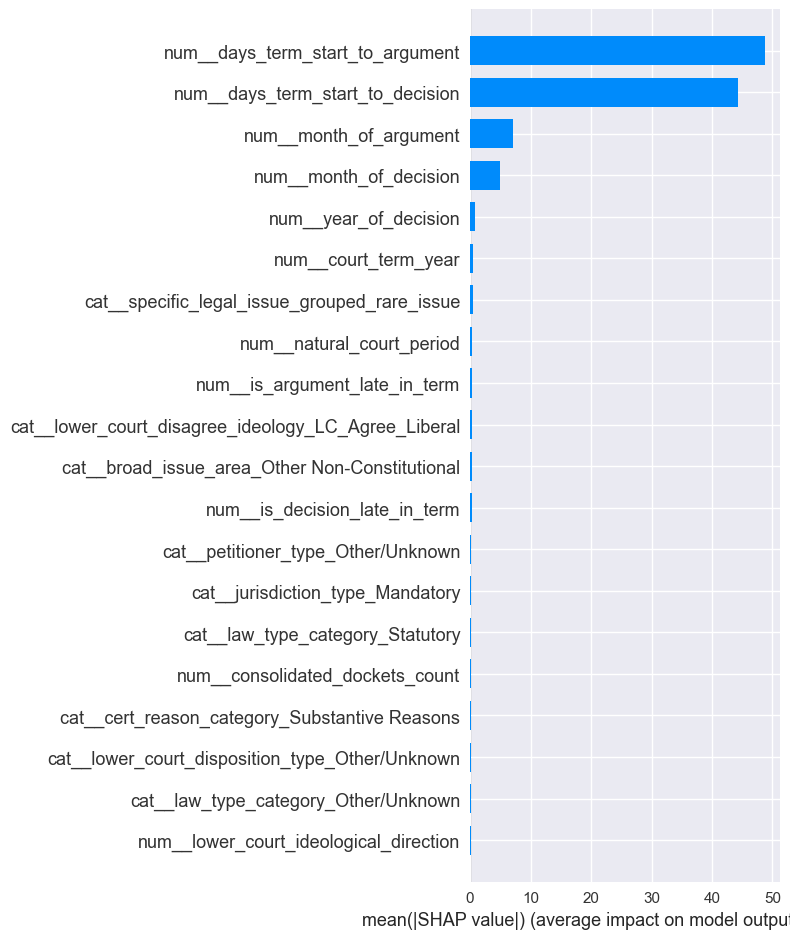

In [87]:
shap.summary_plot(shap_values, X_test_processed_df, plot_type="bar", show=True)

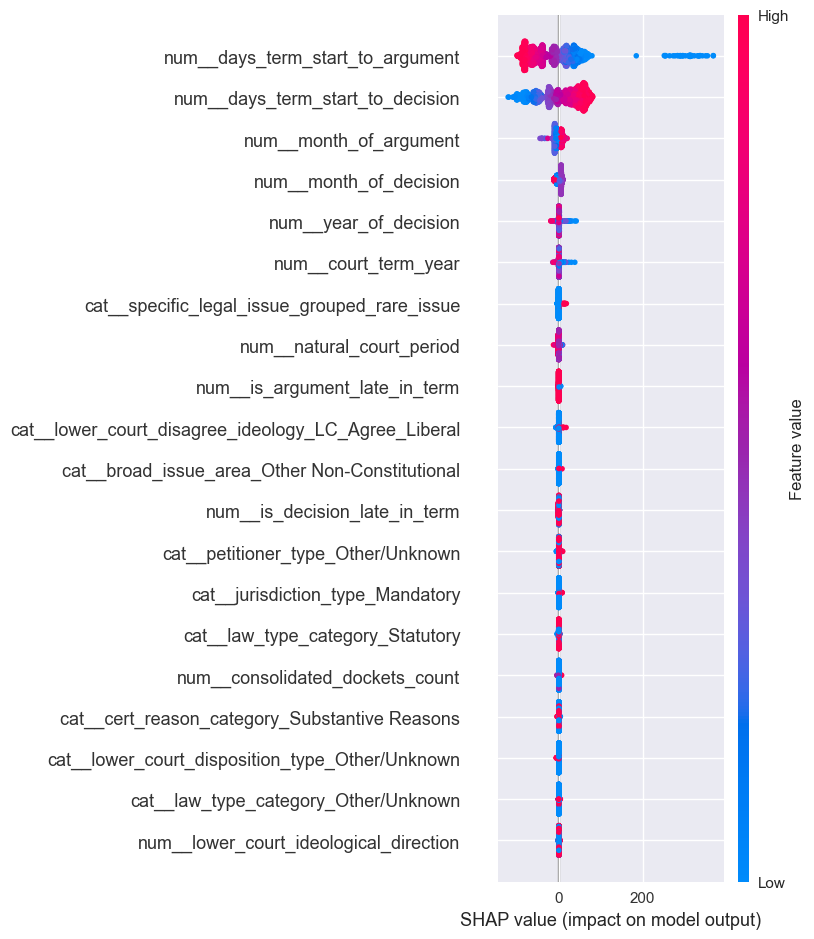

In [88]:
shap.summary_plot(shap_values, X_test_processed_df, show=True)

In [89]:
# Replace 'your_feature_name' with an actual column name from X_test_processed_df
shap.dependence_plot("your_feature_name", shap_values, X_test_processed_df, interaction_index="auto", show=True)

ValueError: Could not find feature named: your_feature_name

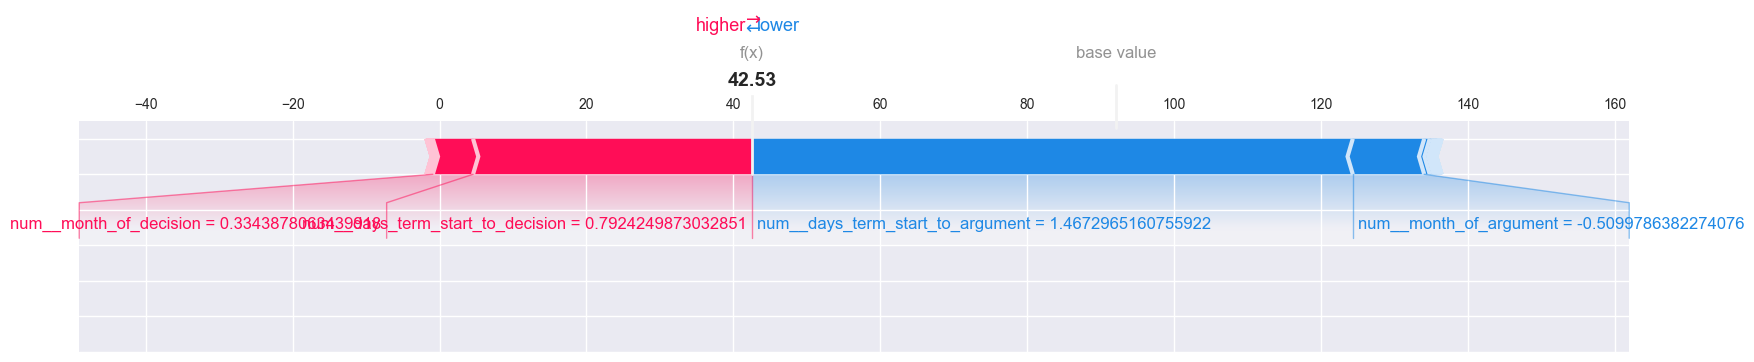

In [90]:
# For the first instance in the test set
# Make sure to use explainer_shap.expected_value (or explainer.expected_value[0] if it's an array)
# shap_values[0,:] assumes shap_values is a 2D numpy array.
shap.force_plot(explainer_shap.expected_value, shap_values[0,:], X_test_processed_df.iloc[0,:], matplotlib=True, show=True)

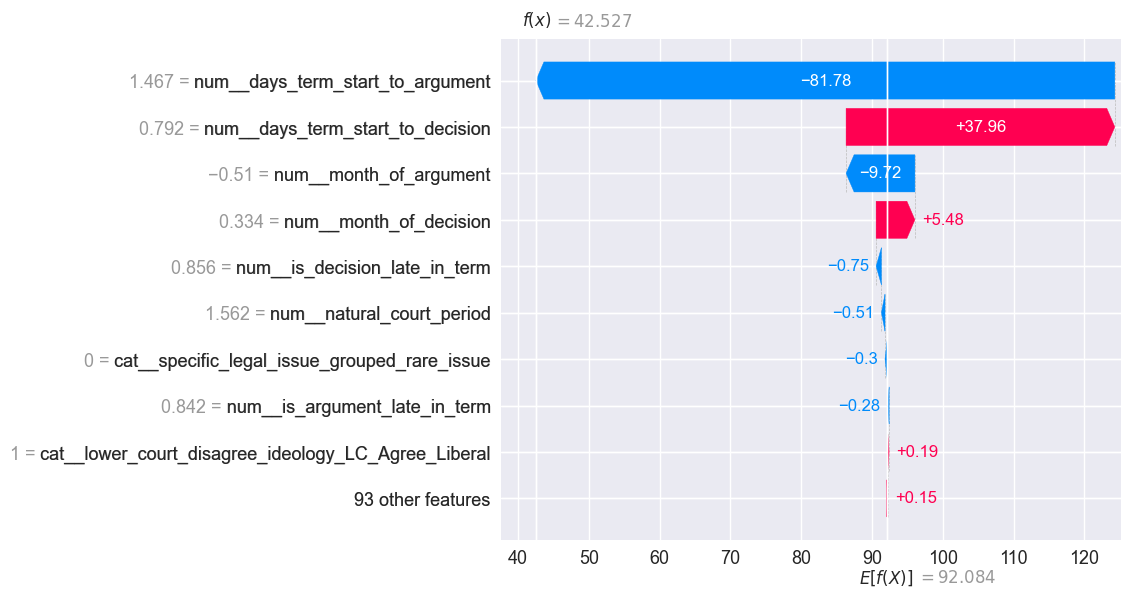

TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.

In [91]:
shap_instance = shap.Explanation(values=shap_values[0], base_values=explainer_shap.expected_value,
                                data=X_test_processed_df.iloc[0].values, feature_names=X_test_processed_df.columns)
shap.plots.waterfall(shap_instance, show=True)
#Or, if shap_values is directly compatible:
shap.plots.waterfall(shap_values[0], show=True) # Check SHAP documentation for exact usage

In [92]:
shap.force_plot(explainer_shap.expected_value, shap_values[:100,:], X_test_processed_df.iloc[:100,:], show=True) # For first 100 samples

In [100]:
y

0       313.0
1       404.0
2       404.0
3       404.0
4       404.0
        ...  
9529     64.0
9530     64.0
9531     67.0
9532    126.0
9533    126.0
Name: case_duration_days, Length: 9534, dtype: float64

In [101]:
import dalex as dx

# Assuming 'pipeline' is your trained sklearn pipeline from results
# 'X_test_original' is your test data BEFORE preprocessing (DALEX can handle the pipeline)
# 'y_test' is the actual target values for the test set

# Create a DALEX explainer object
explainer_dalex = dx.Explainer(
    model=pipeline,          # Your scikit-learn pipeline
    data=X_current,    # DALEX will pass this through the pipeline's preprocessor
    y=y,                # True target values
    label="XGBoost_Optuna_FullSet", # A label for your model
    verbose=False            # Set to True for more logs
)
print("DALEX explainer created.")

DALEX explainer created.


In [102]:
fi_dalex = explainer_dalex.model_parts(loss_function='rmse') # Or use default
# You can also use: fi_dalex = explainer_dalex.feature_importance(type='raw', loss_function='rmse')
fi_dalex.plot(show=True)

In [103]:
# For a single numeric variable
# Replace 'your_numeric_feature' with a column name from X_test_original
pdp_dalex_single = explainer_dalex.model_profile(variables=['your_numeric_feature'], type='partial') # or 'ale'
pdp_dalex_single.plot(show=True)

# For a single categorical variable
# Replace 'your_categorical_feature' with a column name from X_test_original
# pdp_dalex_cat = explainer_dalex.model_profile(variables=['your_categorical_feature'], type='partial', categorical_variables=['your_categorical_feature'])
# pdp_dalex_cat.plot(show=True)

ValueError: Invalid variable names

In [105]:
# For the first instance in the test set
single_instance_original = X_current.iloc[[0]]

# Break Down plot (additive attributions)
bd_dalex = explainer_dalex.predict_parts(new_observation=single_instance_original, type='break_down')
bd_dalex.plot(show=True, max_vars=15) # Show top 15 contributing features

# DALEX can also compute SHAP-like explanations
# shap_dalex = explainer_dalex.predict_parts(new_observation=single_instance_original, type='shap', B=10) # B is number of permutations for SHAP
# shap_dalex.plot(show=True, max_vars=15)

In [106]:
md_dalex = explainer_dalex.model_diagnostics()
md_dalex.plot(variable="y_hat", yvariable="residuals", show=True) # Residuals vs Fitted
md_dalex.plot(variable="y", yvariable="y_hat", show=True)       # Actual vs Predicted

Top 10 features for dependence plots: ['num__days_term_start_to_argument', 'num__days_term_start_to_decision', 'num__month_of_argument', 'num__month_of_decision', 'num__year_of_decision', 'num__court_term_year', 'cat__specific_legal_issue_grouped_rare_issue', 'num__natural_court_period', 'num__is_argument_late_in_term', 'cat__lower_court_disagree_ideology_LC_Agree_Liberal']

Generating SHAP dependence plot for: num__days_term_start_to_argument


<Figure size 800x550 with 0 Axes>

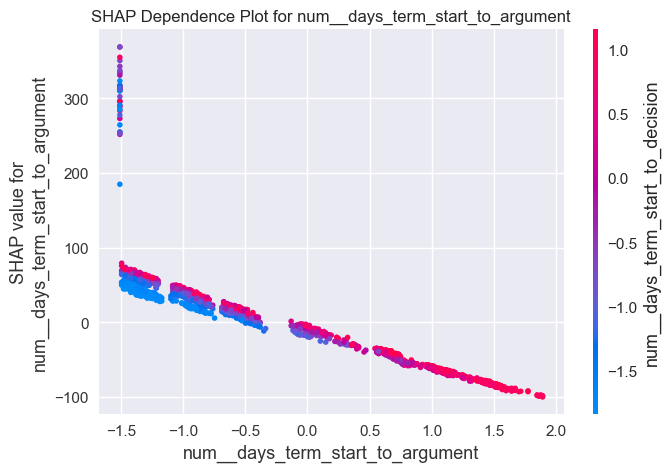


Generating SHAP dependence plot for: num__days_term_start_to_decision


<Figure size 800x550 with 0 Axes>

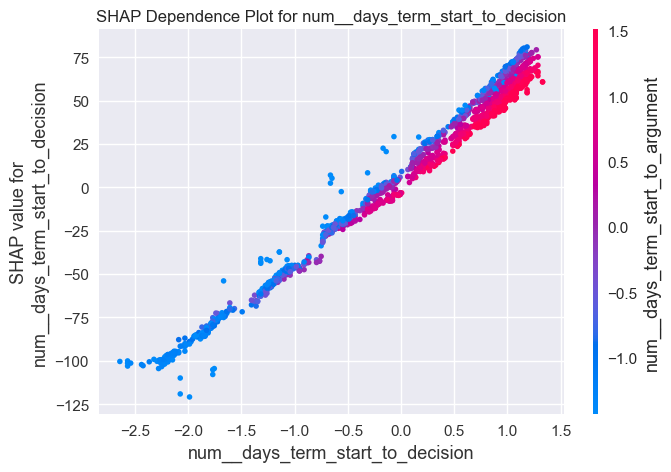


Generating SHAP dependence plot for: num__month_of_argument


<Figure size 800x550 with 0 Axes>

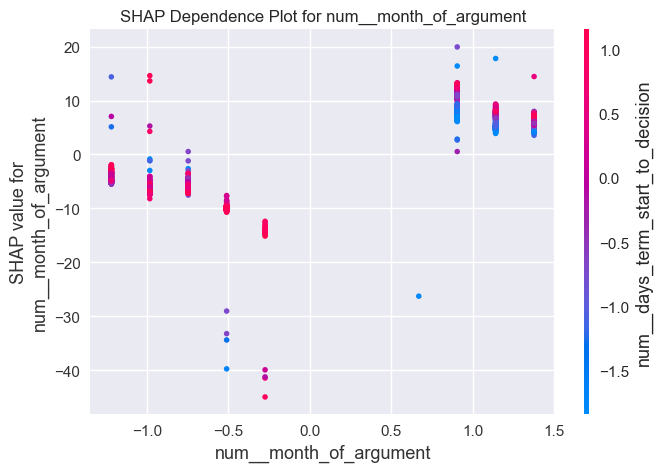


Generating SHAP dependence plot for: num__month_of_decision


<Figure size 800x550 with 0 Axes>

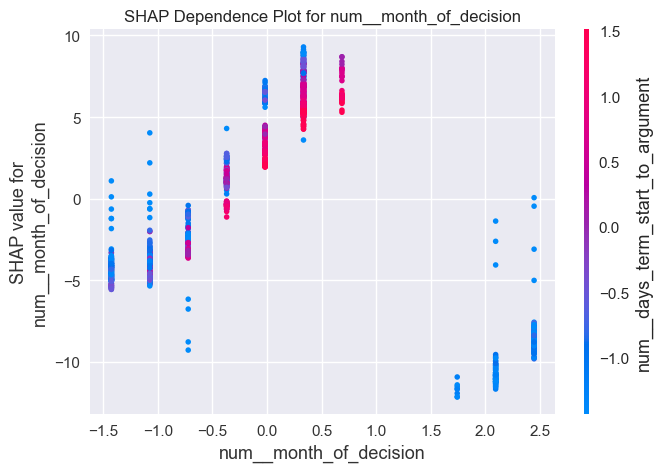


Generating SHAP dependence plot for: num__year_of_decision


<Figure size 800x550 with 0 Axes>

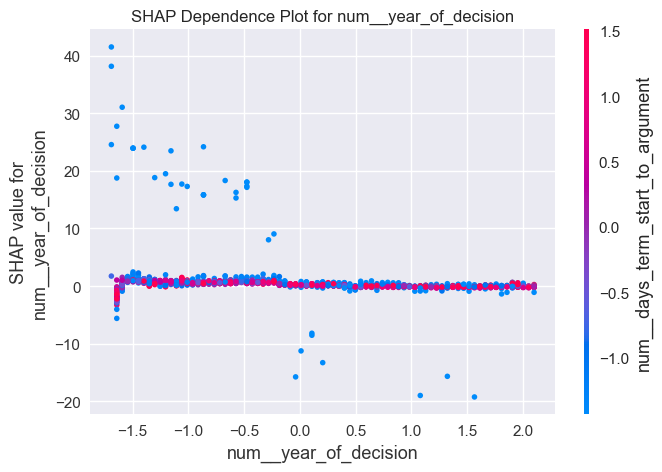


Generating SHAP dependence plot for: num__court_term_year


<Figure size 800x550 with 0 Axes>

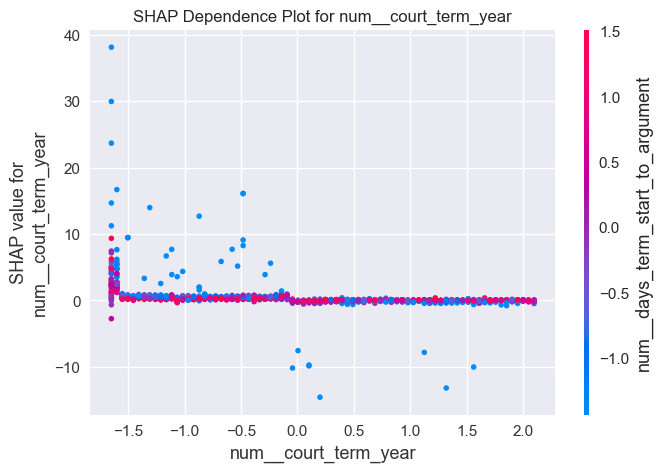


Generating SHAP dependence plot for: cat__specific_legal_issue_grouped_rare_issue


<Figure size 800x550 with 0 Axes>

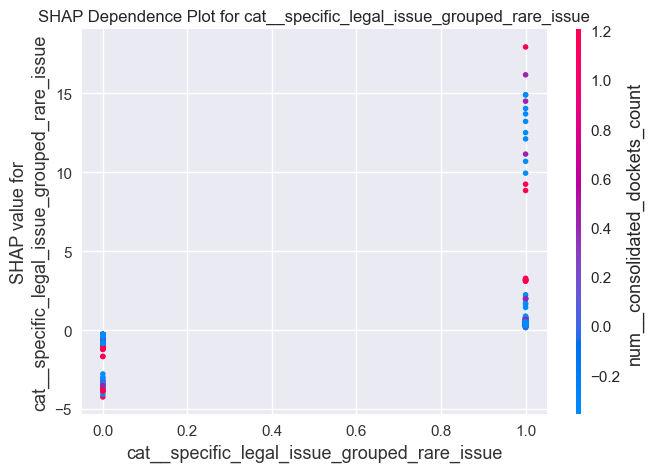


Generating SHAP dependence plot for: num__natural_court_period


<Figure size 800x550 with 0 Axes>

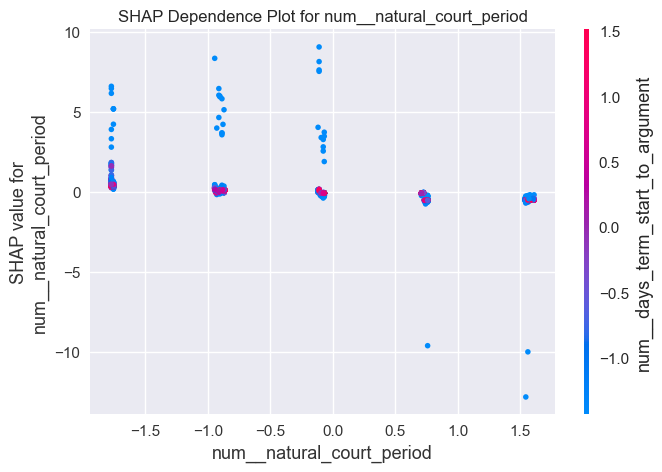


Generating SHAP dependence plot for: num__is_argument_late_in_term


<Figure size 800x550 with 0 Axes>

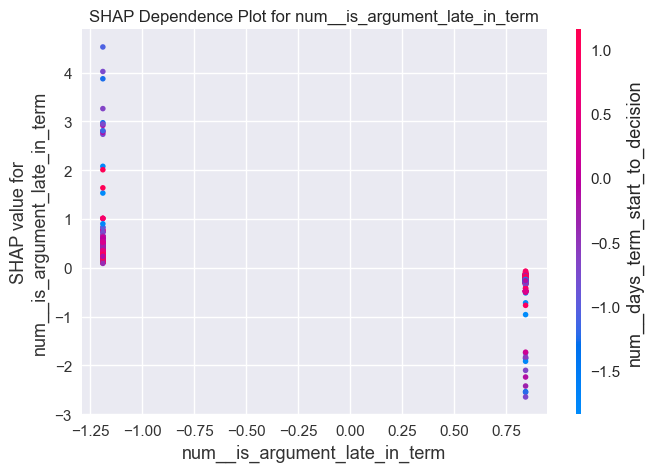


Generating SHAP dependence plot for: cat__lower_court_disagree_ideology_LC_Agree_Liberal


<Figure size 800x550 with 0 Axes>

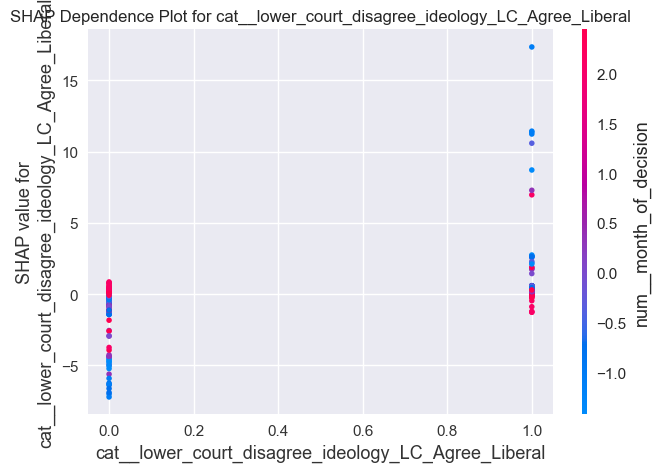

In [107]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # For displaying plots

# --- ASSUMPTIONS ---
# - 'explainer_shap' is your trained shap.TreeExplainer (or other SHAP explainer)
# - 'shap_values' are the calculated SHAP values for X_test_processed_df
# - 'X_test_processed_df' is your preprocessed test data (Pandas DataFrame)

if 'shap_values' in locals() and 'X_test_processed_df' in locals():
    # --- Step 1: Get Top 10 Feature Names ---
    # Calculate mean absolute SHAP values for each feature
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    
    # Create a DataFrame for easy sorting and indexing
    # Ensure feature_names correspond to columns of X_test_processed_df and order of shap_values
    feature_names = X_test_processed_df.columns
    shap_importance_df = pd.DataFrame({
        'feature': feature_names,
        'mean_abs_shap': mean_abs_shap
    }).sort_values(by='mean_abs_shap', ascending=False)

    top_10_features = shap_importance_df['feature'].head(10).tolist()
    print(f"Top 10 features for dependence plots: {top_10_features}")

    # --- Step 2: Loop and Plot ---
    for feature_name in top_10_features:
        try:
            print(f"\nGenerating SHAP dependence plot for: {feature_name}")
            # Create a new figure for each plot to avoid overlap if not in a notebook
            # that clears plots automatically.
            plt.figure()
            shap.dependence_plot(
                feature_name,
                shap_values,
                X_test_processed_df,
                interaction_index="auto", # Let SHAP pick a good interaction feature
                show=False # Set to False to manage display/saving manually
            )
            plt.title(f"SHAP Dependence Plot for {feature_name}")
            plt.show() # Display the plot
            # If saving to a PDF, you'd handle it with your PdfPages object here
            # For example: pdf.savefig(plt.gcf(), bbox_inches='tight')
            # plt.close() # Close the figure after showing/saving
        except Exception as e:
            print(f"Could not generate dependence plot for {feature_name}: {e}")
else:
    print("Error: 'shap_values' or 'X_test_processed_df' not defined. Please calculate them first.")

In [109]:
# Example: Getting and rounding values for a specific instance (e.g., the first one)
instance_index = 0
if 'shap_values' in locals() and 'X_test_processed_df' in locals() and \
   'explainer_shap' in locals() and hasattr(explainer_shap, 'expected_value'):

    print(f"\n--- Explaining instance {instance_index} ---")
    print(f"Base value (average prediction): {explainer_shap.expected_value:.2f}")
    prediction = explainer_shap.expected_value + shap_values[instance_index,:].sum()
    print(f"Model prediction for instance: {prediction:.2f}")

    print("\nFeature contributions (rounded to 2 decimal places):")
    for i, feature_name in enumerate(X_test_processed_df.columns):
        shap_val = shap_values[instance_index, i]
        feature_val = X_test_processed_df.iloc[instance_index, i]
        if abs(shap_val) > 0.01: # Show only significant contributions
            print(f"  Feature: {feature_name} (value: {feature_val:.2f if isinstance(feature_val, float) else feature_val}), SHAP Value: {shap_val:.2f}")

    # Then generate the force plot as usual
    shap.force_plot(explainer_shap.expected_value,
                    shap_values[instance_index,:],
                    X_test_processed_df.iloc[instance_index,:],
                    matplotlib=True, show=True)
else:
    print("Required SHAP objects not found for detailed explanation.")


--- Explaining instance 0 ---
Base value (average prediction): 92.08
Model prediction for instance: 42.53

Feature contributions (rounded to 2 decimal places):


ValueError: Invalid format specifier '.2f if isinstance(feature_val, float) else feature_val' for object of type 'float'

In [110]:
import shap
shap.initjs()

In [111]:
import dalex as dx
import matplotlib.pyplot as plt # For displaying plots

# --- ASSUMPTIONS ---
# - 'explainer_dalex' is your trained dalex.Explainer object
# - 'X_test_original' is your original test data (before preprocessing if DALEX handles pipeline)

if 'explainer_dalex' in locals():
    # --- Step 1: Get Top 10 Feature Names from DALEX ---
    # Permutation-based feature importance
    fi_dalex = explainer_dalex.model_parts(loss_function='rmse', N=None) # N=None uses all data
    # The result 'fi_dalex.result' is a DataFrame
    # It usually has 'variable' and 'dropout_loss' columns.
    # Sort by dropout_loss (higher means more important)
    # Ensure the column name for importance is correct based on your DALEX version/output.
    # It could be 'dropout_loss' or something similar. Let's assume 'dropout_loss'.
    # Filter out _baseline_ and _full_model_ if present
    fi_df = fi_dalex.result[~fi_dalex.result['variable'].isin(['_baseline_', '_full_model_'])]
    top_10_features_dalex = fi_df.sort_values(by='dropout_loss', ascending=False)['variable'].head(10).tolist()
    print(f"Top 10 features from DALEX for PDP/ALE: {top_10_features_dalex}")

    # --- Step 2: Loop and Plot PDP/ALE ---
    for feature_name in top_10_features_dalex:
        try:
            print(f"\nGenerating DALEX model profile (ALE or PDP) for: {feature_name}")
            # DALEX model_profile can take a list of variables.
            # For individual plots per feature:
            mp_dalex = explainer_dalex.model_profile(
                variables=[feature_name],
                type='ale', # Or 'partial' for PDP, 'conditional'
                # For categorical features, DALEX usually handles them automatically.
                # If needed, you can specify: categorical_variables=[feature_name] if it's categorical
            )
            mp_dalex.plot(show=True)
            # If saving to a PDF, DALEX plots can sometimes be tricky with PdfPages directly.
            # You might need to save individual plots to image files first, or use fig.show() and save manually.
            # For matplotlib-based plots from DALEX, plt.gcf() and pdf.savefig() might work.
        except Exception as e:
            print(f"Could not generate DALEX model profile for {feature_name}: {e}")
else:
    print("Error: 'explainer_dalex' not defined. Please create it first.")

Top 10 features from DALEX for PDP/ALE: ['days_term_start_to_argument', 'days_term_start_to_decision', 'month_of_argument', 'month_of_decision', 'year_of_decision', 'court_term_year', 'specific_legal_issue_grouped', 'lower_court_disagree_ideology', 'natural_court_period', 'cert_reason_category']

Generating DALEX model profile (ALE or PDP) for: days_term_start_to_argument


Calculating accumulated dependency: 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]



Generating DALEX model profile (ALE or PDP) for: days_term_start_to_decision


Calculating accumulated dependency: 100%|██████████| 1/1 [00:00<00:00, 13.54it/s]



Generating DALEX model profile (ALE or PDP) for: month_of_argument


Calculating accumulated dependency: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]



Generating DALEX model profile (ALE or PDP) for: month_of_decision


Calculating accumulated dependency: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]



Generating DALEX model profile (ALE or PDP) for: year_of_decision


Calculating accumulated dependency: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]



Generating DALEX model profile (ALE or PDP) for: court_term_year


Calculating accumulated dependency: 100%|██████████| 1/1 [00:00<00:00, 13.45it/s]



Generating DALEX model profile (ALE or PDP) for: specific_legal_issue_grouped


Calculating ceteris paribus: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Could not generate DALEX model profile for specific_legal_issue_grouped: There are no numerical variables

Generating DALEX model profile (ALE or PDP) for: lower_court_disagree_ideology


Calculating ceteris paribus: 100%|██████████| 1/1 [00:00<00:00, 34.58it/s]


Could not generate DALEX model profile for lower_court_disagree_ideology: There are no numerical variables

Generating DALEX model profile (ALE or PDP) for: natural_court_period


Calculating accumulated dependency: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s]



Generating DALEX model profile (ALE or PDP) for: cert_reason_category


Calculating ceteris paribus: 100%|██████████| 1/1 [00:00<00:00, 43.59it/s]


Could not generate DALEX model profile for cert_reason_category: There are no numerical variables


In [114]:
%pip install lime

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283918 sha256=8befcab9901de285a121adfba2f14eb5edb347c156ac77ff864afbdb0cedf6bb
  Stored in directory: c:\users\macie\appdata\local\pip\cache\wheels\e7\5d\0e\4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
Note: you may need to restart the kernel to use updated packages.


In [115]:
import lime
import lime.lime_tabular

# Assuming 'pipeline' is your trained sklearn pipeline
# 'X_train_processed_df' for creating the explainer (needs feature names, training data stats)
# 'X_test_processed_df' to get an instance to explain

# LIME needs data in numpy array format for the explainer usually
# and often benefits from knowing categorical features if not one-hot encoded prior to LIME
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_processed_df.values, # Or a sample
    feature_names=X_train_processed_df.columns.tolist(),
    class_names=['duration_days'], # For regression, can be the target name
    mode='regression',
    # categorical_features=[index_of_cat_feature1, index_of_cat_feature2], # Indices if any are not OHE
    # discretize_continuous=True # Can help sometimes
)

instance_to_explain = X_test_processed_df.iloc[[0]].values[0] # Single instance as numpy array
explanation_lime = lime_explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=pipeline.predict, # Function that takes numpy array and returns predictions
    num_features=10 # Number of features to include in the explanation
)

explanation_lime.show_in_notebook(show_table=True, show_all=False)
# explanation_lime.as_list() # To get (feature, weight) pairs

NameError: name 'X_train_processed_df' is not defined